In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from datetime import date
import sqlite3
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels
import statsmodels.graphics.tsaplots as sgt
from scipy.stats import probplot, moment
from arch import arch_model
from arch.__future__ import reindexing
from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf,q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy.random import seed
from numpy import arange
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import keras
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import pmdarima as pm
from matplotlib import pyplot
database = sqlite3.connect("Dataset.db")
data = pd.read_sql_query("SELECT * FROM Data", database)
data = data.rename(columns={"('EURUSD Curncy', 'PX_LAST')": "EURUSD","('EURCHF Curncy', 'PX_LAST')": "EURCHF","('EURDKK Curncy', 'PX_LAST')":"EURDKK","('EURGBP Curncy', 'PX_LAST')": "EURGBP","('EURCAD Curncy', 'PX_LAST')": "EURCAD","('EURAUD Curncy', 'PX_LAST')": "EURAUD","('EURJPY Curncy', 'PX_LAST')": "EURJPY","('EURNOK Curncy', 'PX_LAST')": "EURNOK","('EURSEK Curncy', 'PX_LAST')": "EURSEK"})
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
indexed_df = data.set_index('date')
ts_eurusd = indexed_df['EURUSD']
seed(8)

In [2]:
from pylab import rcParams 
import warnings
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 16,8

In [3]:
ts_eurusd = ts_eurusd['2019-01-02':'2022-04-15']

In [4]:
euribor = pd.read_excel("Euribor.xlsx")
euribor = euribor.iloc[:,[0,1]]
euribor['Date'] = pd.to_datetime(euribor['Date'])
indexed_df = euribor.set_index('Date')
ts_euribor = indexed_df["Euribor"]
euribor_2 = pd.read_excel("Euribor_1.xlsx")
euribor_2['Date'] = pd.to_datetime(euribor_2['Unnamed: 0'])
indexed_df = euribor_2.set_index('Date')
ts_euribor_2 = indexed_df["Euribor"]
ts_euribor_2
ts_euribor = pd.concat([ts_euribor, ts_euribor_2]).sort_index()
ts_euribor = ts_euribor.dropna()
ts_euribor = ts_euribor/100

In [5]:
libor = pd.read_csv("LIBORUSD3M_NEW_1.CSV")
libor['Close'] = libor['Close'].str.rstrip("%").astype(float)/100
libor['Date'] = pd.to_datetime(libor['Date'])
indexed_df = libor.set_index('Date')
ts_libor = indexed_df['Close']
libor_2 = pd.read_csv("LIBORUSD3M_NEW_2.CSV")
libor_2['Close'] = libor_2['Close'].str.rstrip("%").astype(float)/100
libor_2['Date'] = pd.to_datetime(libor_2['Date'])
indexed_df = libor_2.set_index('Date')
ts_libor_2 = indexed_df['Close']
libor_3 = pd.read_csv("LIBORUSD3M_NEW_3.CSV")
libor_3['Close'] = libor_3['Close'].str.rstrip("%").astype(float)/100
libor_3['Date'] = pd.to_datetime(libor_3['Date'])
indexed_df = libor_3.set_index('Date')
ts_libor_3 = indexed_df['Close']
libor_4 = pd.read_csv("LIBORUSD3M_NEW_4.CSV")
libor_4['Close'] = libor_4['Close'].str.rstrip("%").astype(float)/100
libor_4['Date'] = pd.to_datetime(libor_4['Date'])
indexed_df = libor_4.set_index('Date')
ts_libor_4 = indexed_df['Close']
s3= pd.concat([ts_libor, ts_libor_2]).sort_index()
s4 = pd.concat([s3, ts_libor_3]).sort_index()
ts_libor = pd.concat([s4, ts_libor_4]).sort_index()
ts_libor = ts_libor.dropna()


In [6]:
fwd_rates = ts_libor.to_frame().join(ts_euribor.to_frame())
fwd_rates = fwd_rates.dropna()
fwd_rates.rename(columns={'Close': 'Libor $'}, inplace=True)


In [7]:
impl_vol = pd.read_csv("VolatilityScanner_DataDeck_AtTheMoneyVols_EURUSD.CSV")
impl_vol['date'] = pd.to_datetime(impl_vol['date'])
indexed_df = impl_vol.set_index('date')
impl_vol['EURUSDV1M Curncy'] = impl_vol['EURUSDV1M Curncy']/100
ts_impl_vol = indexed_df['EURUSDV3M Curncy']
ts_impl_vol = ts_impl_vol/100
ts_impl_vol = ts_impl_vol.dropna()
fwd_rates = fwd_rates.join(ts_impl_vol.to_frame())
fwd_rates.rename(columns={'EURUSDV3M Curncy': 'Implied_Vol3M'}, inplace=True)
fwd_rates

Libor $  Euribor  Implied_Vol3M
Date                                        
2019-01-02  0.027939 -0.00310       0.063025
2019-01-03  0.027950 -0.00309       0.058500
2019-01-04  0.028039 -0.00309       0.055925
2019-01-07  0.027968 -0.00310       0.052500
2019-01-08  0.027825 -0.00308       0.059125
...              ...      ...            ...
2022-04-08  0.010107 -0.00449       0.100650
2022-04-11  0.010214 -0.00435       0.108775
2022-04-12  0.010384 -0.00433            NaN
2022-04-13  0.010443 -0.00448       0.075025
2022-04-14  0.010627 -0.00452       0.075175

[835 rows x 3 columns]

In [8]:
def BS_Pricer(S,K,rf,rd,sigma,T,option_type):
    d1 = (np.log(S/K)+(rd-rf+0.5*sigma**2*T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        price = S * np.exp(-rf * T) * norm.cdf(d1) - K * np.exp(-rd * T) * norm.cdf(d2)
    if option_type == 'put':
        price = K * np.exp(-rd * T) * norm.cdf(-d2) - S * np.exp(-rf * T) * norm.cdf(-d1)
    return (price)

In [9]:
returns_series = np.log(ts_eurusd).diff().dropna()

In [10]:
ann_volatility_25 = (returns_series.rolling(window = 25).std()*np.sqrt(252)).dropna()
ann_volatility_50 = (returns_series.rolling(window = 50).std()*np.sqrt(252)).dropna()
ann_volatility_100 = (returns_series.rolling(window = 100).std()*np.sqrt(252)).dropna()

In [11]:
full_data = fwd_rates.join(ts_eurusd.to_frame())
full_data['Historical_Volatility'] = ann_volatility_25
full_data = full_data.dropna()
full_data['Maturity'] = 0.25
full_data['Strike'] = full_data['EURUSD']
full_data

Libor $  Euribor  Implied_Vol3M  EURUSD  Historical_Volatility  \
Date                                                                          
2019-02-07  0.026970 -0.00308       0.051000  1.1341               0.062826   
2019-02-08  0.026978 -0.00308       0.060400  1.1323               0.062974   
2019-02-12  0.026929 -0.00308       0.046850  1.1326               0.061145   
2019-02-13  0.026838 -0.00308       0.063600  1.1261               0.055184   
2019-02-14  0.026939 -0.00308       0.065500  1.1295               0.055817   
...              ...      ...            ...     ...                    ...   
2022-04-07  0.009889 -0.00465       0.093975  1.0879               0.101487   
2022-04-08  0.010107 -0.00449       0.100650  1.0877               0.093590   
2022-04-11  0.010214 -0.00435       0.108775  1.0884               0.091021   
2022-04-13  0.010443 -0.00448       0.075025  1.0888               0.076552   
2022-04-14  0.010627 -0.00452       0.075175  1.0828               0.074275   

            Maturity  Strike  
Date                          
2019-02-07      0.25  1.1341  
2019-02-08      0.25  1.1323  
2019-02-12      0.25  1.1326  
2019-02-13      0.25  1.1261  
2019-02-14      0.25  1.1295  
...              ...     ...  
2022-04-07      0.25  1.0879  
2022-04-08      0.25  1.0877  
2022-04-11      0.25  1.0884  
2022-04-13      0.25  1.0888  
2022-04-14      0.25  1.0828  

[714 rows x 7 columns]

In [12]:
S = full_data['EURUSD']#Spot price
K = S #Strike Price At-the-Money Option
rf = full_data['Euribor']    # Euribor 3m rate 
rd = full_data['Libor $']    # Dollar Libor 3m rate
sigma = full_data['Historical_Volatility']
T = 0.25 #3-month Maturity

In [13]:
BS_Pricer(S,K,rf,rd,sigma,T,'call')

Date
2019-02-07    0.016023
2019-02-08    0.016033
2019-02-12    0.015597
2019-02-13    0.014095
2019-02-14    0.014290
                ...   
2022-04-07    0.023543
2022-04-08    0.021795
2022-04-11    0.021236
2022-04-13    0.018042
2022-04-14    0.017447
Length: 714, dtype: float64

In [14]:
BS_Pricer(S,K,rf,rd,sigma,T,'put')

Date
2019-02-07    0.007528
2019-02-08    0.007550
2019-02-12    0.007125
2019-02-13    0.005697
2019-02-14    0.005839
                ...   
2022-04-07    0.019591
2022-04-08    0.017829
2022-04-11    0.017276
2022-04-13    0.013983
2022-04-14    0.013350
Length: 714, dtype: float64

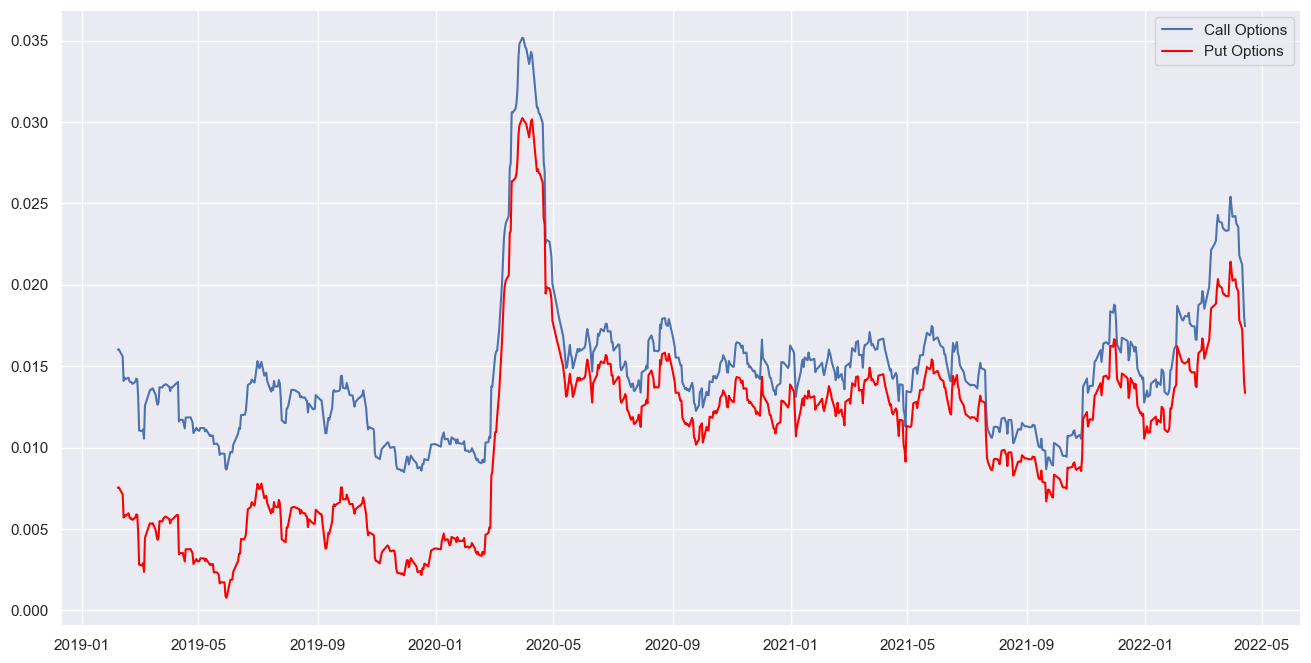

In [15]:
plt.plot(BS_Pricer(S,K,rf,rd,sigma,T,'call').index.to_pydatetime(), BS_Pricer(S,K,rf,rd,sigma,T,'call').values)
plt.plot(BS_Pricer(S,K,rf,rd,sigma,T,'put').index.to_pydatetime(), BS_Pricer(S,K,rf,rd,sigma,T,'put').values,color = 'red')
plt.legend(['Call Options','Put Options'])

In [16]:
def BS_delta(S,K,rf,rd,sigma,T,option_type):
    d1 = (np.log(S/K)+(rd-rf+sigma**2/2*T))/(sigma*np.sqrt(T))
    if option_type == 'call':
        delta = np.exp(-rf*T)*norm.cdf(d1)
    if option_type == 'put':
        delta = np.exp(-rf*T)*(-norm.cdf(-d1))
    return (delta)  

In [17]:
def BS_gamma(S,K,rf,rd,sigma,T,option_type):
    d1 = (np.log(S/K)+(rd-rf+sigma**2/2*T))/(sigma*np.sqrt(T))
    if option_type == 'call':
        gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
    if option_type == 'put':
        gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
    return (gamma)

In [18]:
def BS_vega(S,K,rf,rd,sigma,T,option_type):
    d1 = (np.log(S/K)+(rd-rf+sigma**2/2*T))/(sigma*np.sqrt(T))
    if option_type == 'call':
        vega = S*np.exp(-rf * T)*np.sqrt(T)*norm.pdf(d1)
    if option_type == 'put':
        vega = S*np.sqrt(T)*norm.pdf(d1)*np.exp(-rf * T)
    return (vega)
    

In [19]:
def BS_volga(S,K,rf,rd,sigma,T):
    d1 = (np.log(S/K)+(rd-rf+sigma**2/2*T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    volga = S*np.exp(-rf*T)*np.sqrt(T)*norm.pdf(d1)*((d1*d2)/sigma)
    return volga

In [20]:
def BS_vanna(S,K,rf,rd,sigma,T):
    d1 = (np.log(S/K)+(rd-rf+sigma**2/2*T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    vanna = -np.exp(-rf*T)*np.sqrt(T)*norm.pdf(d1)*(d2/sigma)
    return vanna

In [21]:
g_c = BS_gamma(S,K,rf,rd,sigma,T,'call')
g_p = BS_gamma(S,K,rf,rd,sigma,T,'put')

In [22]:
vega_c = BS_vega(S,K,rf,rd,sigma,T,'call')
vega_p = BS_vega(S,K,rf,rd,sigma,T,'put')
vega_c

Date
2019-02-07    0.141116
2019-02-08    0.141163
2019-02-12    0.137565
2019-02-13    0.123015
2019-02-14    0.124540
                ...   
2022-04-07    0.206943
2022-04-08    0.205333
2022-04-11    0.204940
2022-04-13    0.199980
2022-04-14    0.197439
Length: 714, dtype: float64

In [23]:
greeks = pd.DataFrame()
greeks['delta_c'] = BS_delta(S,K,rf,rd,sigma,T,'call')
greeks['delta_p'] = BS_delta(S,K,rf,rd,sigma,T,'put')
greeks

delta_c   delta_p
Date                          
2019-02-07  0.835196 -0.165574
2019-02-08  0.834703 -0.166067
2019-02-12  0.841229 -0.159541
2019-02-13  0.864581 -0.136189
2019-02-14  0.862714 -0.138056
...              ...       ...
2022-04-07  0.623160 -0.378003
2022-04-08  0.632022 -0.369101
2022-04-11  0.634807 -0.366281
2022-04-13  0.659474 -0.341647
2022-04-14  0.665855 -0.335275

[714 rows x 2 columns]

In [24]:
full_data['call'] = BS_Pricer(S,K,rf,rd,sigma,T,'call')
full_data['put'] = BS_Pricer(S,K,rf,rd,sigma,T,'put')
full_data['Straddle'] = full_data['call'] + full_data['put']
full_data

Libor $  Euribor  Implied_Vol3M  EURUSD  Historical_Volatility  \
Date                                                                          
2019-02-07  0.026970 -0.00308       0.051000  1.1341               0.062826   
2019-02-08  0.026978 -0.00308       0.060400  1.1323               0.062974   
2019-02-12  0.026929 -0.00308       0.046850  1.1326               0.061145   
2019-02-13  0.026838 -0.00308       0.063600  1.1261               0.055184   
2019-02-14  0.026939 -0.00308       0.065500  1.1295               0.055817   
...              ...      ...            ...     ...                    ...   
2022-04-07  0.009889 -0.00465       0.093975  1.0879               0.101487   
2022-04-08  0.010107 -0.00449       0.100650  1.0877               0.093590   
2022-04-11  0.010214 -0.00435       0.108775  1.0884               0.091021   
2022-04-13  0.010443 -0.00448       0.075025  1.0888               0.076552   
2022-04-14  0.010627 -0.00452       0.075175  1.0828               0.074275   

            Maturity  Strike      call       put  Straddle  
Date                                                        
2019-02-07      0.25  1.1341  0.016023  0.007528  0.023551  
2019-02-08      0.25  1.1323  0.016033  0.007550  0.023583  
2019-02-12      0.25  1.1326  0.015597  0.007125  0.022722  
2019-02-13      0.25  1.1261  0.014095  0.005697  0.019792  
2019-02-14      0.25  1.1295  0.014290  0.005839  0.020129  
...              ...     ...       ...       ...       ...  
2022-04-07      0.25  1.0879  0.023543  0.019591  0.043134  
2022-04-08      0.25  1.0877  0.021795  0.017829  0.039624  
2022-04-11      0.25  1.0884  0.021236  0.017276  0.038513  
2022-04-13      0.25  1.0888  0.018042  0.013983  0.032025  
2022-04-14      0.25  1.0828  0.017447  0.013350  0.030798  

[714 rows x 10 columns]

In [25]:
S = full_data['EURUSD']#Spot price
K = S #Strike Price At-the-Money Option
rf = full_data['Euribor']    # Euribor 3m rate 
rd = full_data['Libor $']    # Dollar Libor 3m rate
sigma = full_data['Implied_Vol3M']
T = 0.25 #3-month Maturity

In [26]:
full_data['call_impl'] = BS_Pricer(S,K,rf,rd,sigma,T,'call')
full_data['put_impl'] = BS_Pricer(S,K,rf,rd,sigma,T,'put')
full_data['Straddle_impl'] = full_data['call_impl'] + full_data['put_impl']
full_data

Libor $  Euribor  Implied_Vol3M  EURUSD  Historical_Volatility  \
Date                                                                          
2019-02-07  0.026970 -0.00308       0.051000  1.1341               0.062826   
2019-02-08  0.026978 -0.00308       0.060400  1.1323               0.062974   
2019-02-12  0.026929 -0.00308       0.046850  1.1326               0.061145   
2019-02-13  0.026838 -0.00308       0.063600  1.1261               0.055184   
2019-02-14  0.026939 -0.00308       0.065500  1.1295               0.055817   
...              ...      ...            ...     ...                    ...   
2022-04-07  0.009889 -0.00465       0.093975  1.0879               0.101487   
2022-04-08  0.010107 -0.00449       0.100650  1.0877               0.093590   
2022-04-11  0.010214 -0.00435       0.108775  1.0884               0.091021   
2022-04-13  0.010443 -0.00448       0.075025  1.0888               0.076552   
2022-04-14  0.010627 -0.00452       0.075175  1.0828               0.074275   

            Maturity  Strike      call       put  Straddle  call_impl  \
Date                                                                    
2019-02-07      0.25  1.1341  0.016023  0.007528  0.023551   0.013225   
2019-02-08      0.25  1.1323  0.016033  0.007550  0.023583   0.015416   
2019-02-12      0.25  1.1326  0.015597  0.007125  0.022722   0.012269   
2019-02-13      0.25  1.1261  0.014095  0.005697  0.019792   0.016091   
2019-02-14      0.25  1.1295  0.014290  0.005839  0.020129   0.016599   
...              ...     ...       ...       ...       ...        ...   
2022-04-07      0.25  1.0879  0.023543  0.019591  0.043134   0.021881   
2022-04-08      0.25  1.0877  0.021795  0.017829  0.039624   0.023357   
2022-04-11      0.25  1.0884  0.021236  0.017276  0.038513   0.025162   
2022-04-13      0.25  1.0888  0.018042  0.013983  0.032025   0.017700   
2022-04-14      0.25  1.0828  0.017447  0.013350  0.030798   0.017648   

            put_impl  Straddle_impl  
Date                                 
2019-02-07  0.004731       0.017956  
2019-02-08  0.006933       0.022349  
2019-02-12  0.003797       0.016066  
2019-02-13  0.007694       0.023785  
2019-02-14  0.008148       0.024747  
...              ...            ...  
2022-04-07  0.017930       0.039811  
2022-04-08  0.019390       0.042747  
2022-04-11  0.021202       0.046365  
2022-04-13  0.013641       0.031340  
2022-04-14  0.013551       0.031199  

[714 rows x 13 columns]

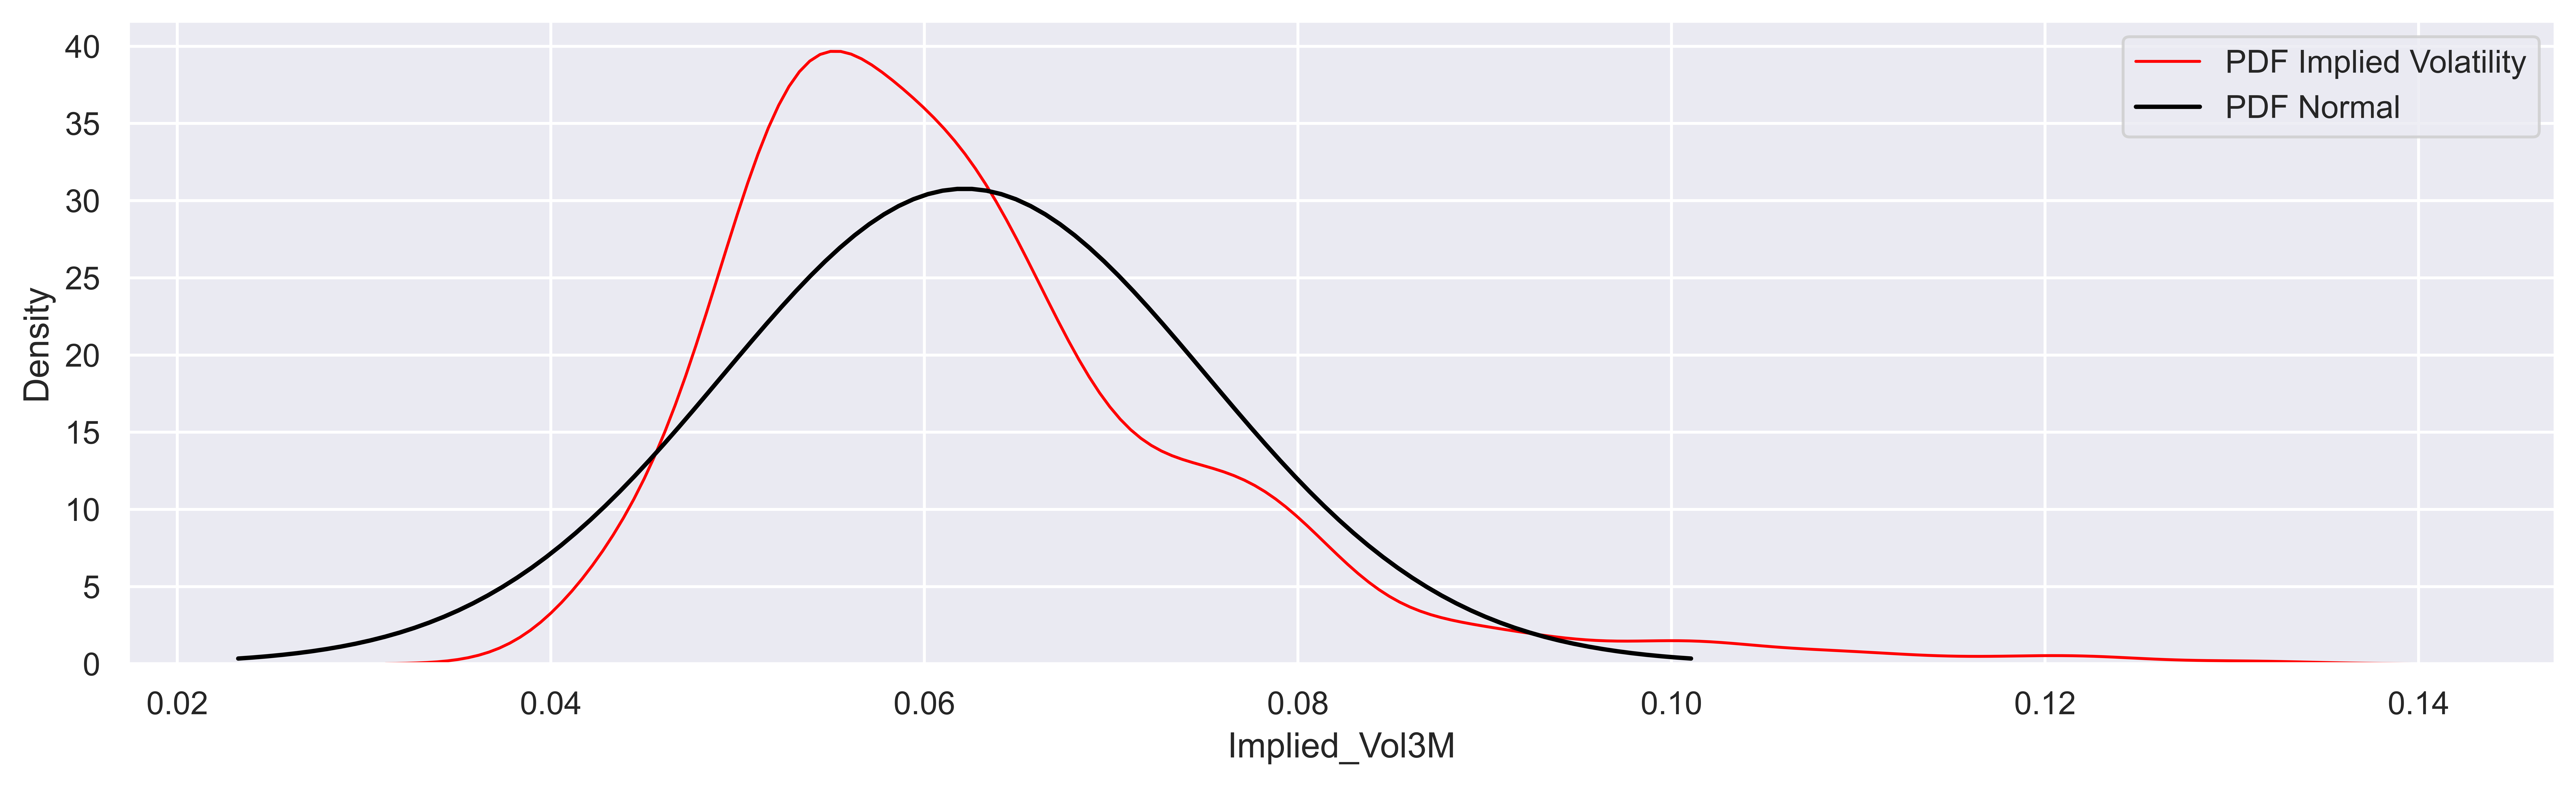

In [27]:
plt.figure(dpi = 1000, figsize=(15, 4))
sns.distplot(full_data["Implied_Vol3M"], hist=False, kde=True, bins=int(180/5), color = 'red',kde_kws={'linewidth': 1})
x = np.linspace(np.mean(full_data["Implied_Vol3M"]) - 3*np.std(full_data["Implied_Vol3M"]), np.mean(full_data["Implied_Vol3M"]) +
3*np.std(full_data["Implied_Vol3M"]), 100)
plt.plot(x, norm.pdf(x, np.mean(full_data["Implied_Vol3M"]), np.std(full_data["Implied_Vol3M"])), color = 'black')
plt.legend(['PDF Implied Volatility', 'PDF Normal'])

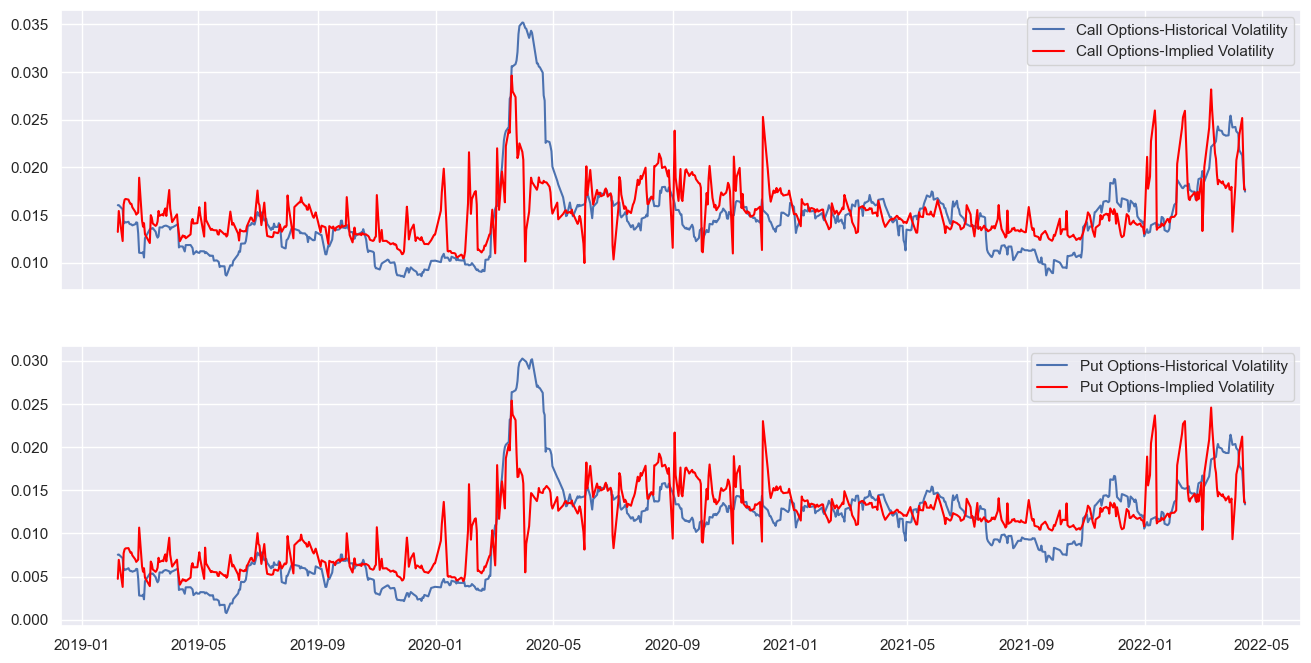

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(full_data['call'])
ax1.plot(full_data['call_impl'], color='red')
ax1.legend(['Call Options-Historical Volatility', 'Call Options-Implied Volatility'])

ax2.plot(full_data['put'])
ax2.plot(full_data['put_impl'], color='red')
ax2.legend(['Put Options-Historical Volatility', 'Put Options-Implied Volatility'])

plt.show()

In [29]:
delta_impl = BS_delta(S,K,rf,rd,sigma,T,'call')
delta_impl_p = BS_delta(S,K,rf,rd,sigma,T,'put')
greeks['delta_impl'] = delta_impl
greeks['delta_impl_p'] = delta_impl_p
greeks

delta_c   delta_p  delta_impl  delta_impl_p
Date                                                    
2019-02-07  0.835196 -0.165574    0.883889     -0.116881
2019-02-08  0.834703 -0.166067    0.844494     -0.156277
2019-02-12  0.841229 -0.159541    0.902650     -0.098121
2019-02-13  0.864581 -0.136189    0.831281     -0.169489
2019-02-14  0.862714 -0.138056    0.825220     -0.175550
...              ...       ...         ...           ...
2022-04-07  0.623160 -0.378003    0.631131     -0.370032
2022-04-08  0.632022 -0.369101    0.624403     -0.376720
2022-04-11  0.634807 -0.366281    0.616666     -0.384422
2022-04-13  0.659474 -0.341647    0.662244     -0.338877
2022-04-14  0.665855 -0.335275    0.664156     -0.336975

[714 rows x 4 columns]

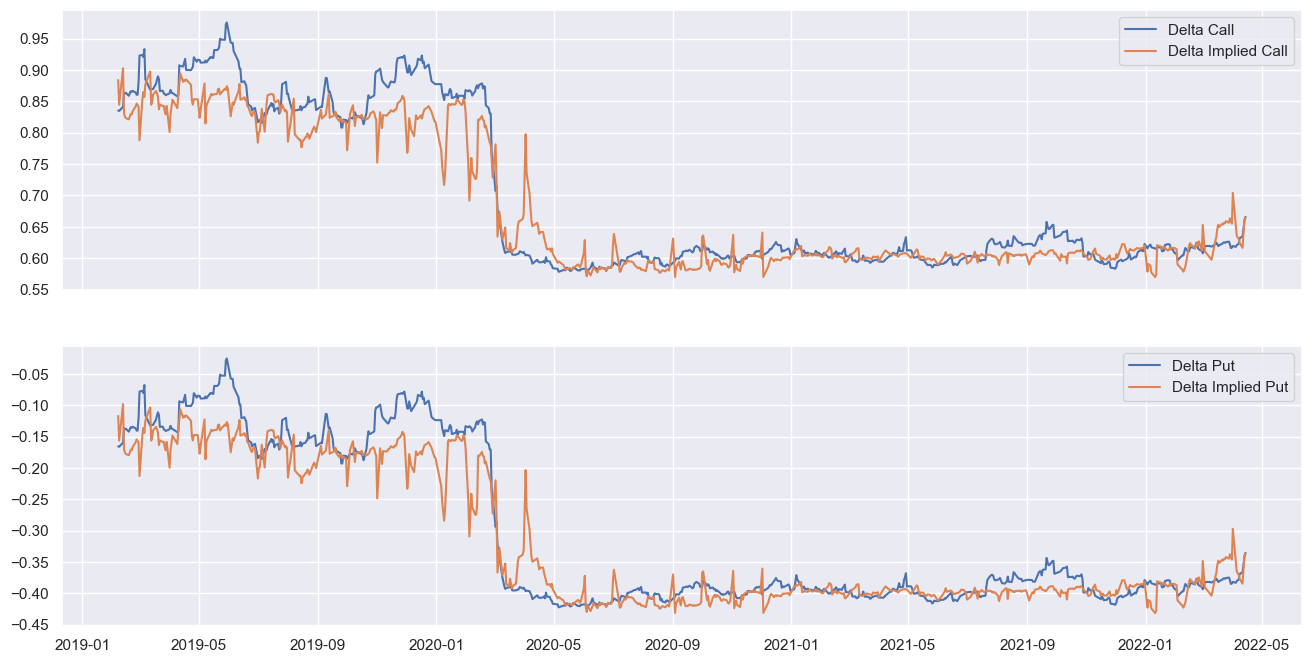

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(greeks['delta_c'])
ax1.plot(greeks['delta_impl'])
ax1.legend(['Delta Call','Delta Implied Call'])

ax2.plot(greeks['delta_p'])
ax2.plot(greeks['delta_impl_p'])
ax2.legend(['Delta Put','Delta Implied Put'])

In [31]:
vega_c_impl = BS_vega(S,K,rf,rd,sigma,T,'call')
vega_p_impl = BS_vega(S,K,rf,rd,sigma,T,'put')

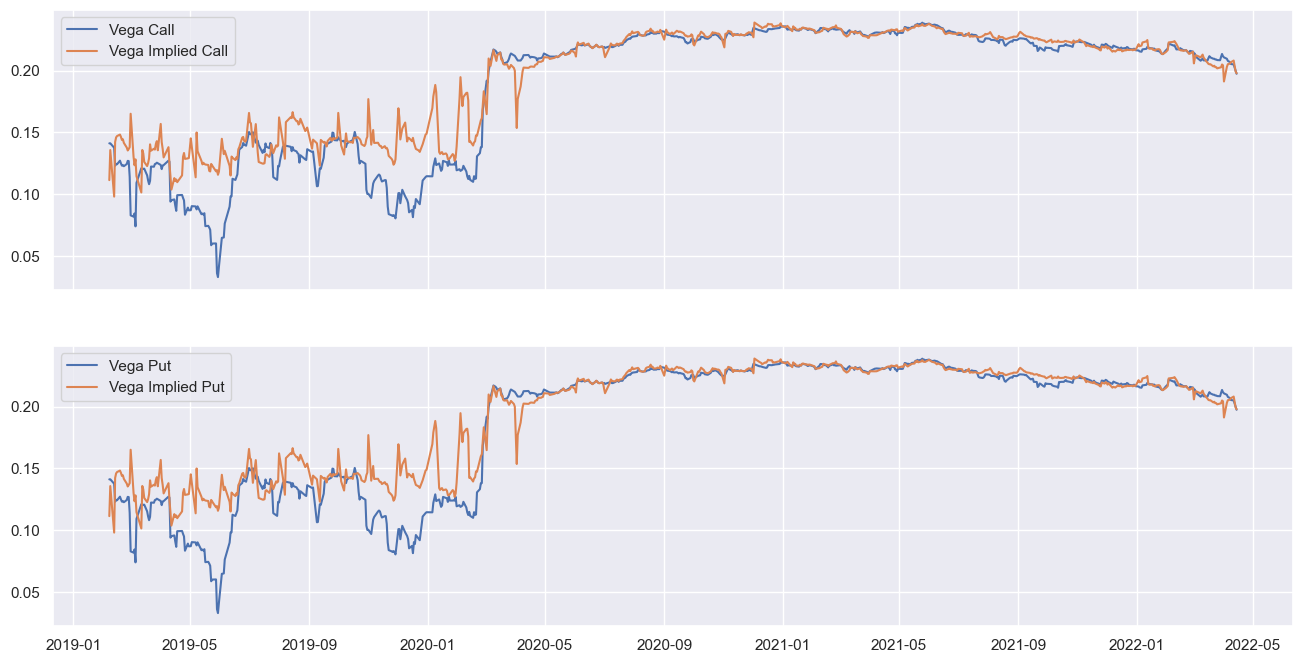

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(vega_c)
ax1.plot(vega_c_impl)
ax1.legend(['Vega Call','Vega Implied Call'])

ax2.plot(vega_p)
ax2.plot(vega_p_impl)
ax2.legend(['Vega Put','Vega Implied Put'])

## Volatility Modelling-Forecasting Using GARCH Models##

In [33]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1],method = 'ywm')
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [34]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

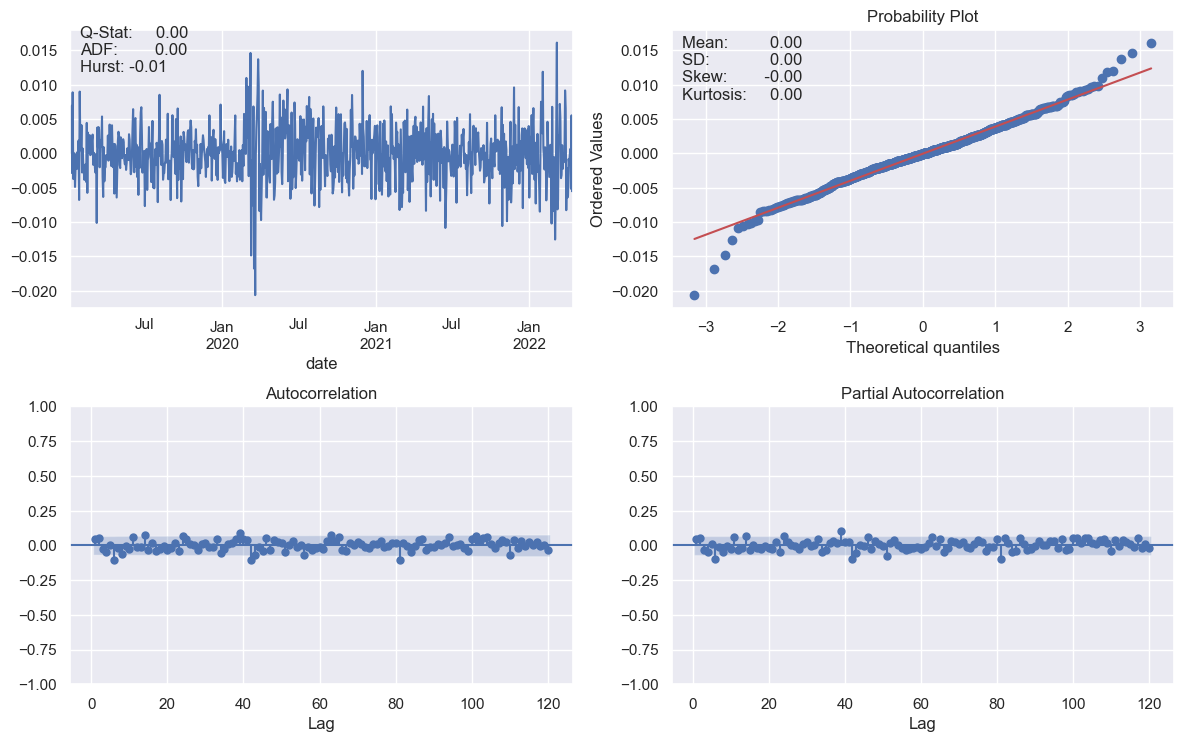

In [35]:
plot_correlogram((returns_series),lags = 120)

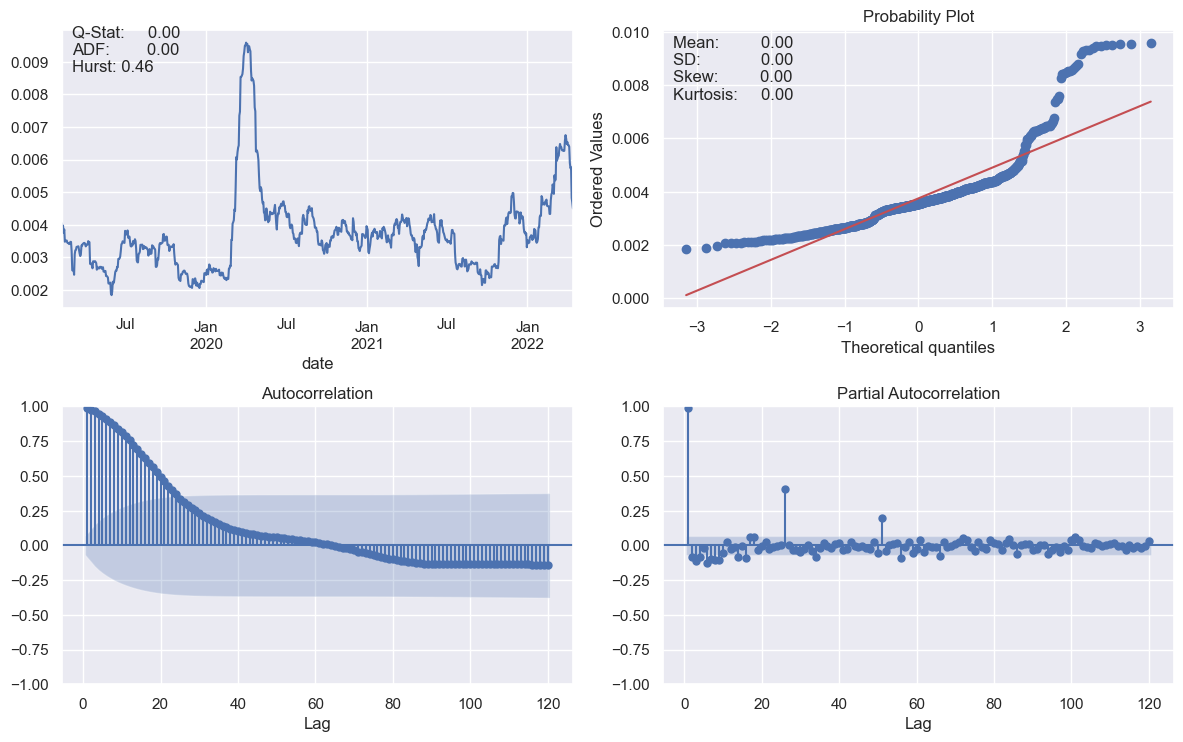

In [36]:
plot_correlogram(returns_series.rolling(window = 25).std().dropna(),lags = 120)

In [37]:
# Specify GARCH model assumptions
basic_gm = arch_model(returns_series, p = 1, q = 1,
                      mean = 'zero', vol = 'GARCH', dist = 'normal',rescale = True)
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)
# Display model fitting summary
print(gm_result.summary())

Iteration:      4,   Func. Count:     26,   Neg. LLF: 377.42407250114877
Iteration:      8,   Func. Count:     44,   Neg. LLF: 373.89929814667613
Optimization terminated successfully    (Exit mode 0)
            Current function value: 373.8992917147367
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 EURUSD   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -373.899
Distribution:                  Normal   AIC:                           753.799
Method:            Maximum Likelihood   BIC:                           768.059
                                        No. Observations:                  857
Date:                Fri, Aug 04 2023   Df Residuals:                      857
Time:        

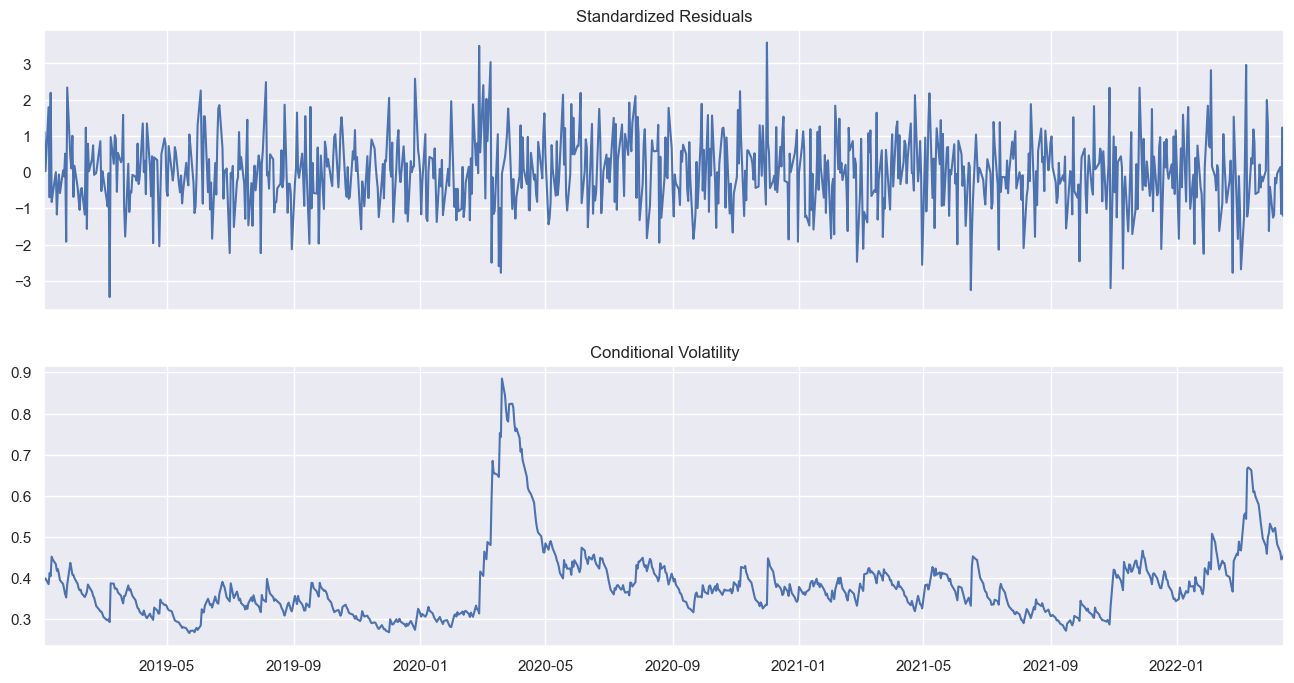

In [38]:
# Plot fitted results
gm_result.plot()
plt.show()

In [39]:
# Make 1-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 1)
forecast_1d_ahead = (gm_forecast.variance[-1:]**0.5 * np.sqrt(252))/100

In [40]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

Text(0.5, 0, 'Filtered residuals')

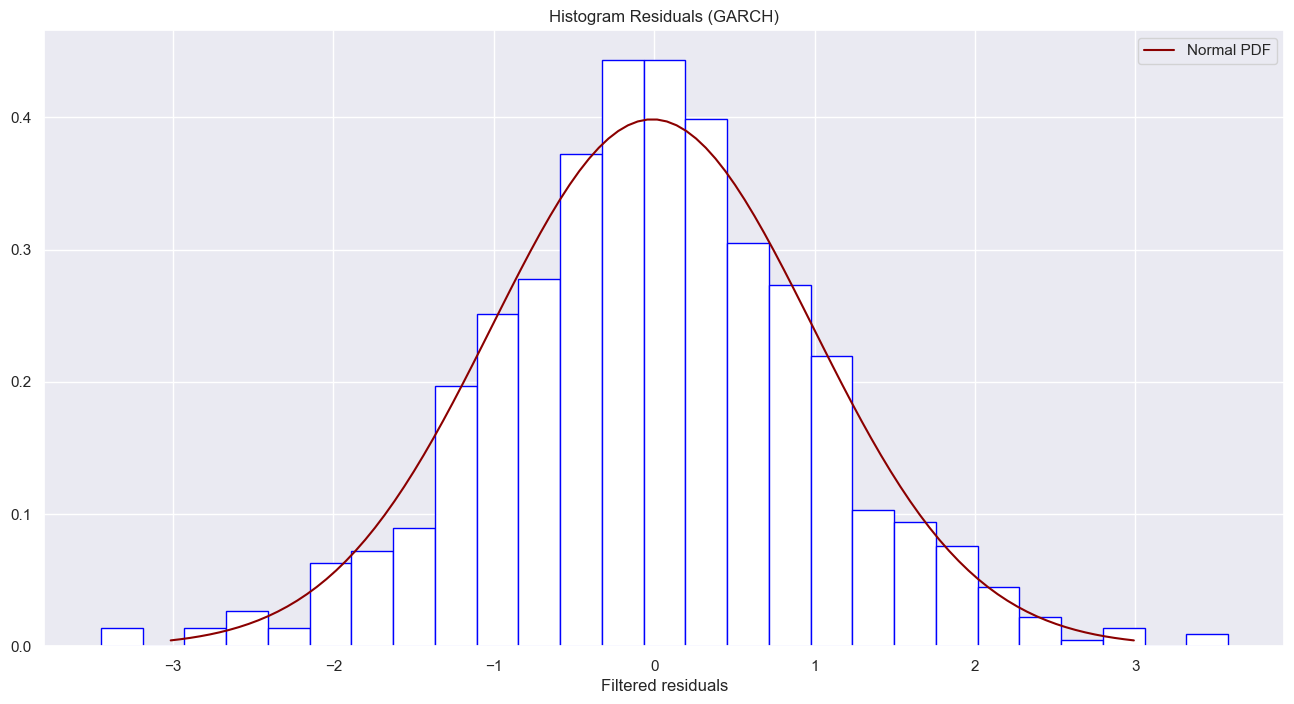

In [41]:
plt.hist(gm_std_resid, bins = "auto", rwidth=2, histtype= 'bar', density = True, color = 'white', stacked=True, edgecolor =
'blue')
x = np.linspace(np.mean(gm_std_resid) - 3*np.std(gm_std_resid), np.mean(gm_std_resid) +
3*np.std(gm_std_resid), 100)
plt.plot(x, norm.pdf(x, np.mean(gm_std_resid), np.std(gm_std_resid)), color = 'darkred', linewidth = 1.5)
plt.legend(['Normal PDF'])
plt.title('Histogram Residuals (GARCH)')
plt.xlabel('Filtered residuals')

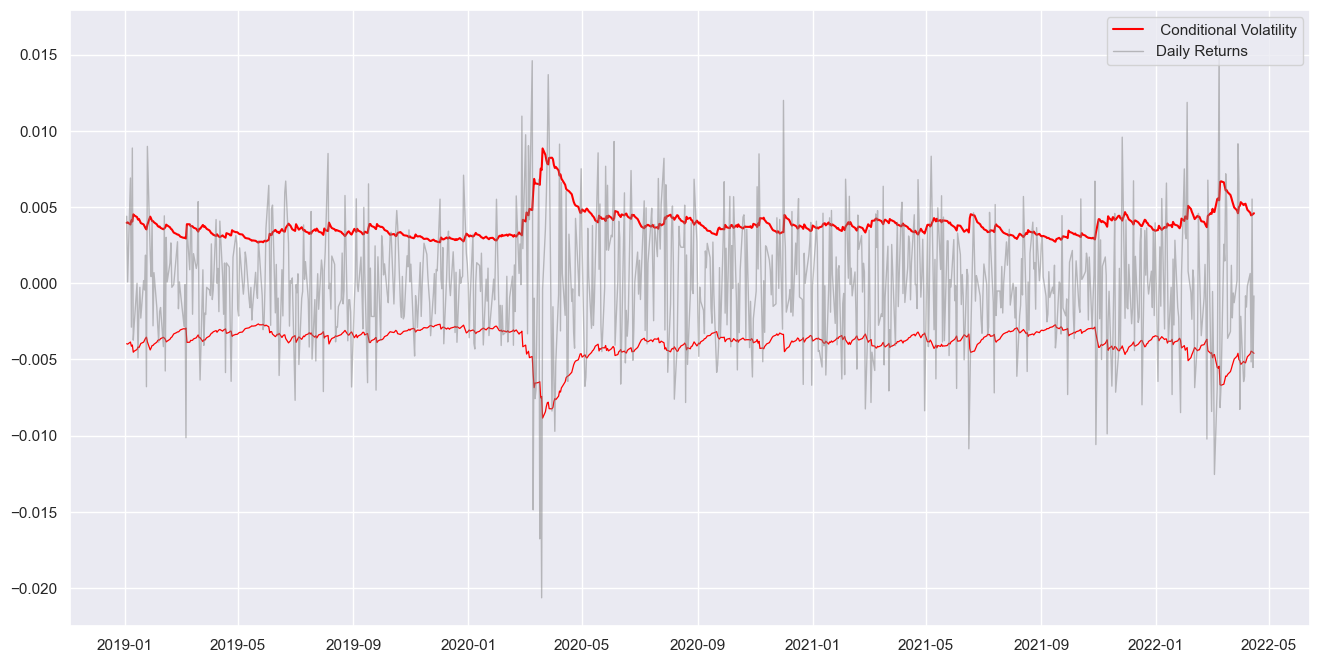

In [42]:
# Plot model fitting results
plt.plot(gm_result.conditional_volatility/100, color = 'red', label = ' Conditional Volatility')
plt.plot(-gm_result.conditional_volatility/100, linewidth = 0.9, color = 'red')
plt.plot(returns_series, linewidth = 1,color = 'grey', 
         label = 'Daily Returns', alpha = 2.5)
plt.legend(loc = 'upper right')
plt.show()

In [43]:
# Specify GARCH model assumptions
skewt_gm = arch_model(returns_series, p = 1, q = 1, mean = 'zero', vol = 'GARCH', dist = 'StudentsT',rescale = True)

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility
print(skewt_result.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                       EURUSD   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -369.934
Distribution:      Standardized Student's t   AIC:                           747.868
Method:                  Maximum Likelihood   BIC:                           766.882
                                              No. Observations:                  857
Date:                      Fri, Aug 04 2023   Df Residuals:                      857
Time:                              14:07:45   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

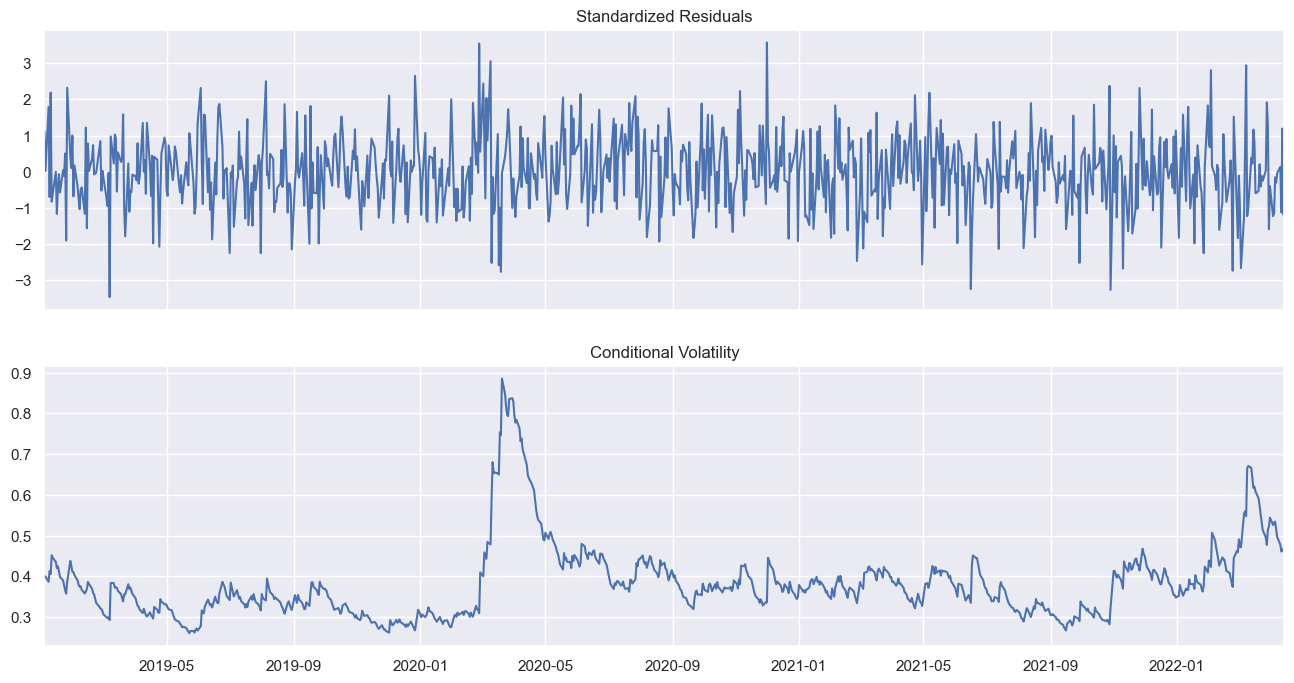

In [44]:
# Plot fitted results
skewt_result.plot()
plt.show()

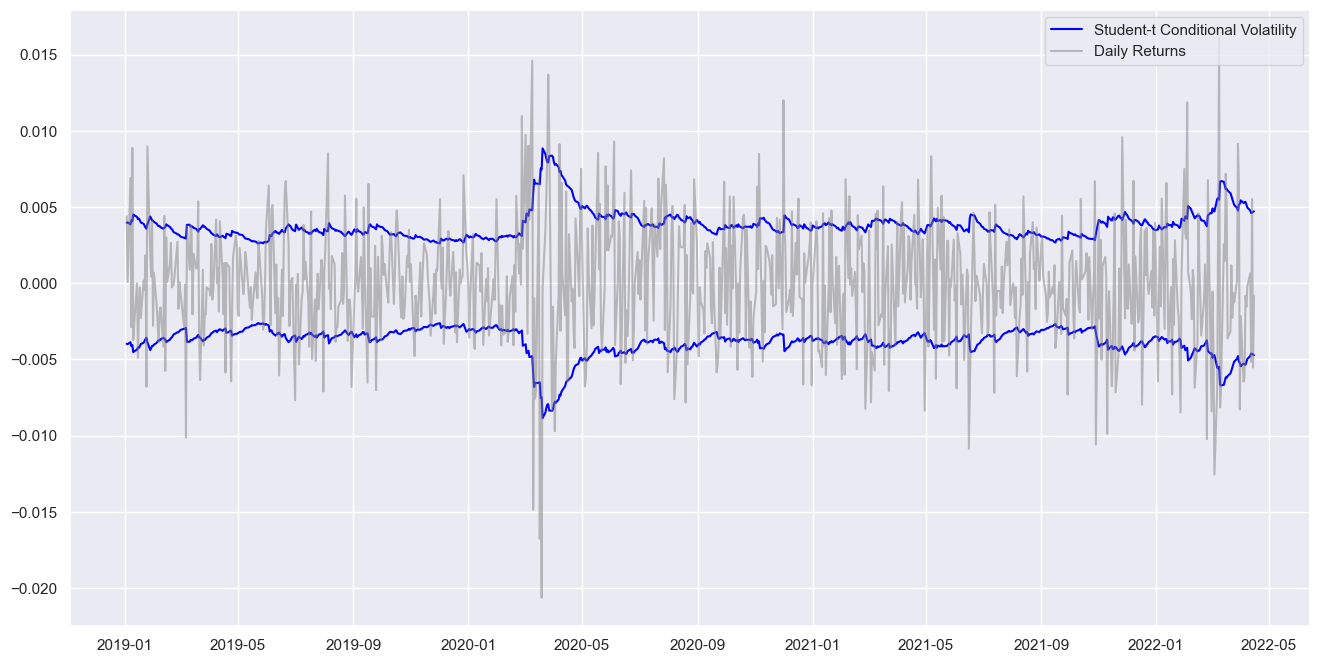

In [45]:
# Plot model fitting results
plt.plot(skewt_vol/100, color = 'blue', label = 'Student-t Conditional Volatility')
plt.plot(-skewt_vol/100, color = 'blue')
plt.plot(returns_series, color = 'grey', 
         label = 'Daily Returns', alpha = 1.5)
plt.legend(loc = 'upper right')
plt.show()

In [46]:
gm_forecast_t = skewt_result.forecast(horizon = 1)
forecast_1d_ahead_t = (gm_forecast_t.variance[-1:]**0.5 * np.sqrt(252))/100

In [47]:
# Specify GARCH model assumptions
egarch_gm = arch_model(returns_series, p = 1, o = 1,q = 1, mean = 'zero', vol = 'EGARCH', dist = 'normal', rescale = True)

# Fit the model
eg_result = egarch_gm.fit(disp = 'off')

# Get model estimated volatility
eg_vol = eg_result.conditional_volatility
print(eg_result.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                 EURUSD   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -377.153
Distribution:                  Normal   AIC:                           762.306
Method:            Maximum Likelihood   BIC:                           781.320
                                        No. Observations:                  857
Date:                Fri, Aug 04 2023   Df Residuals:                      857
Time:                        14:07:46   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         -0.0707  2.666e-02     -2.651  8.026e-03 

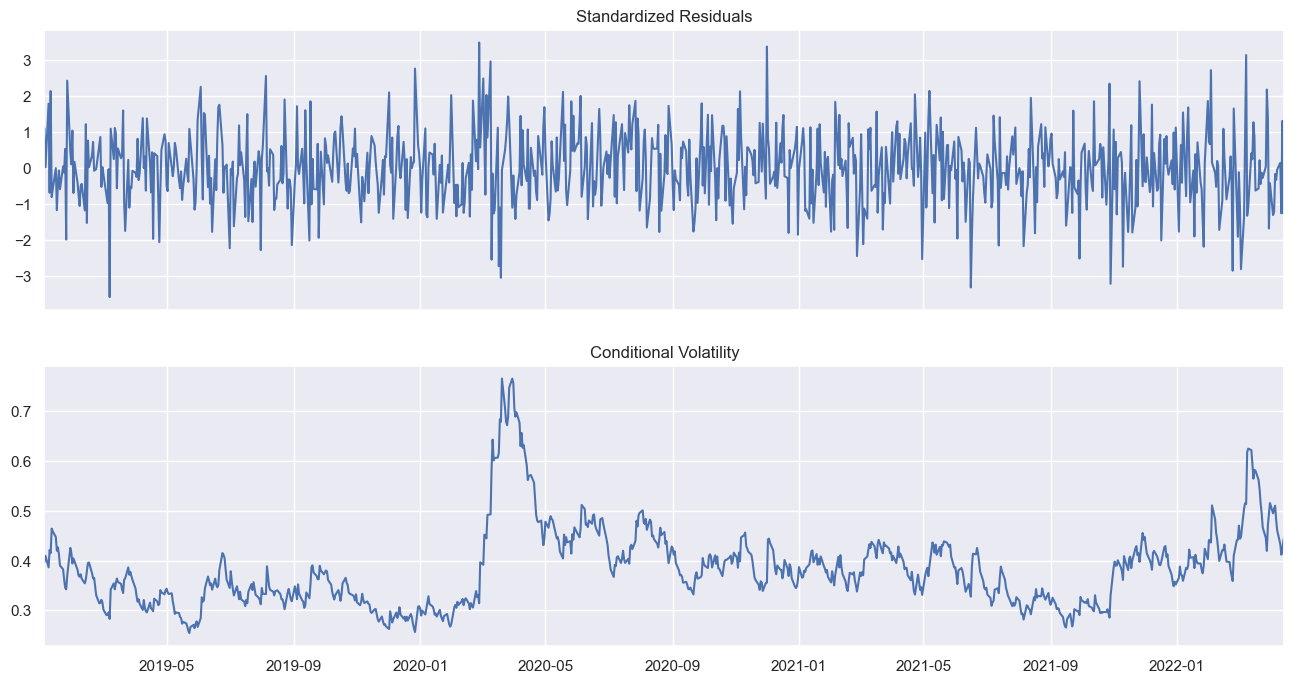

In [48]:
# Plot fitted results
eg_result.plot()
plt.show()

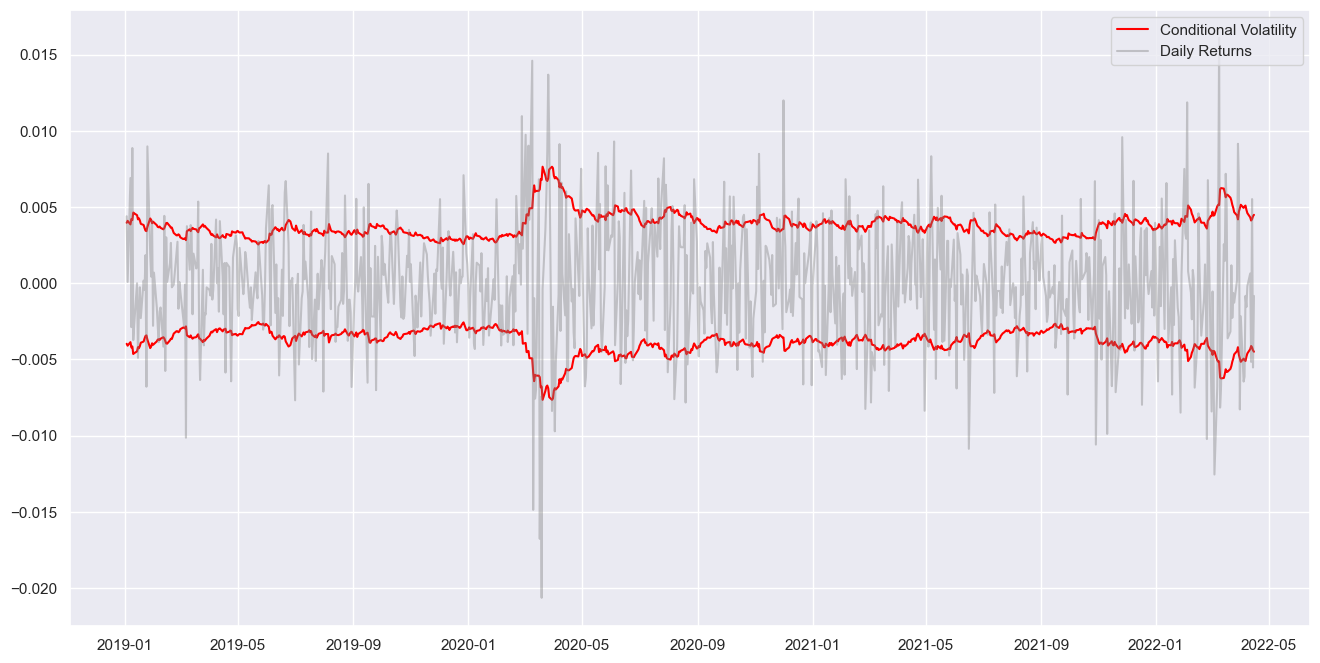

In [49]:
# Plot model fitting results
plt.plot(eg_vol/100, color = 'red', label = 'Conditional Volatility')
plt.plot(-eg_vol/100, color = 'red')
plt.plot(returns_series, color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [50]:
gm_forecast_eg = eg_result.forecast(horizon = 1)
forecast_1d_ahead_eg = (gm_forecast_eg.variance[-1:]**0.5 * np.sqrt(252))/100

In [51]:
# Specify GARCH model assumptions
egarch_gm_t = arch_model(returns_series, p = 1, o = 1,q = 1, mean = 'zero', vol = 'EGARCH', dist = 'StudentsT', rescale = True)

# Fit the model
eg_result_t = egarch_gm_t.fit(disp = 'off')

# Get model estimated volatility
eg_vol_t = eg_result_t.conditional_volatility
print(eg_result_t.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                       EURUSD   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                           EGARCH   Log-Likelihood:               -372.281
Distribution:      Standardized Student's t   AIC:                           754.562
Method:                  Maximum Likelihood   BIC:                           778.329
                                              No. Observations:                  857
Date:                      Fri, Aug 04 2023   Df Residuals:                      857
Time:                              14:07:47   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

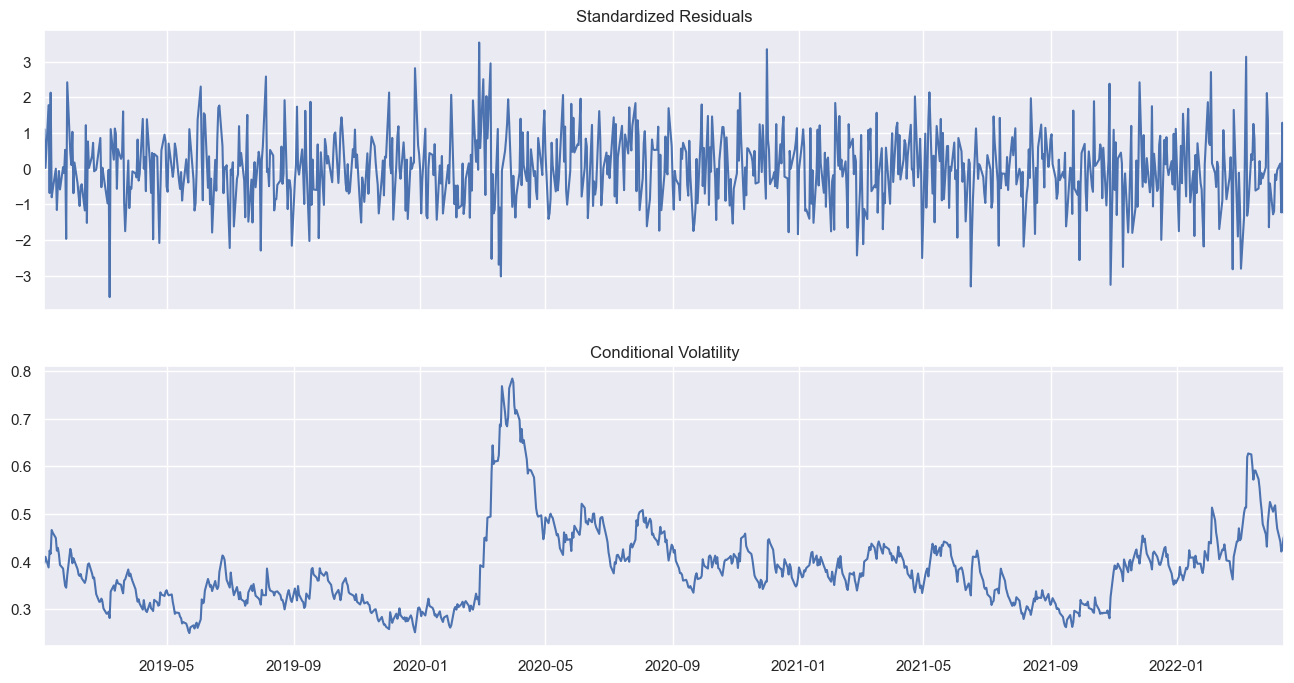

In [52]:
# Plot fitted results
eg_result_t.plot()
plt.show()

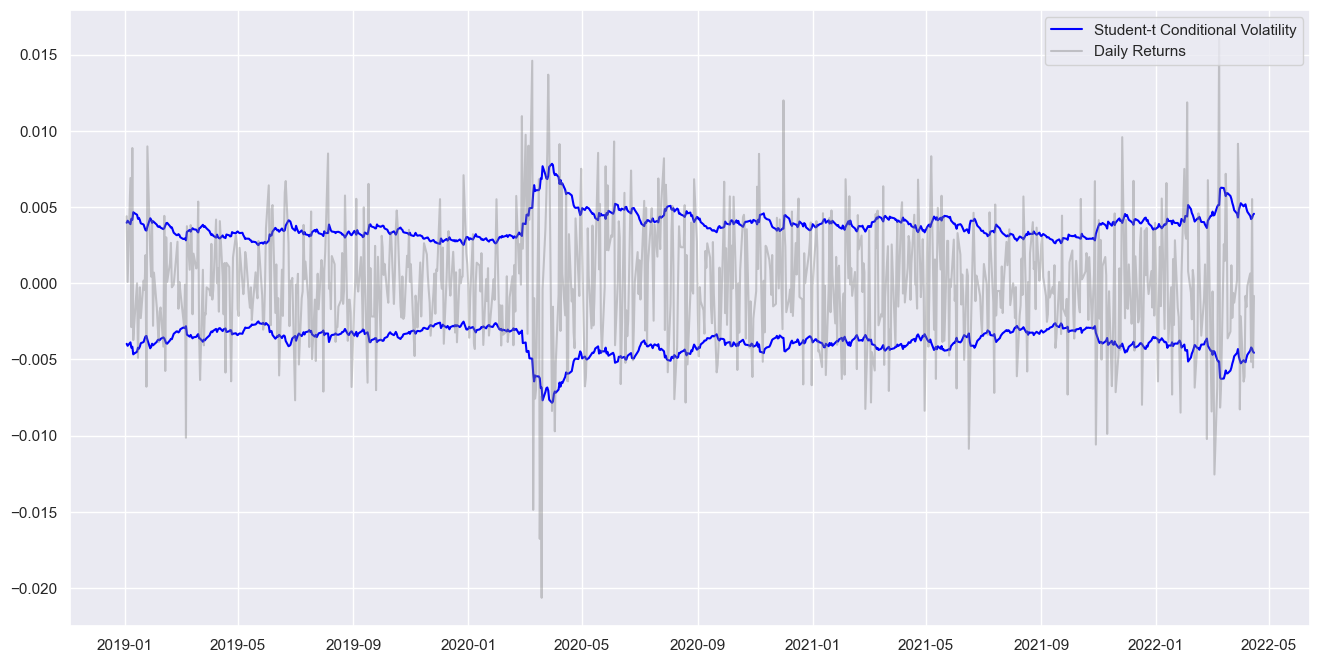

In [53]:
# Plot model fitting results
plt.plot(eg_vol_t/100, color = 'blue', label = 'Student-t Conditional Volatility')
plt.plot(-eg_vol_t/100, color = 'blue')
plt.plot(returns_series, color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [54]:
gm_forecast_eg_t = eg_result_t.forecast(horizon = 1)
forecast_1d_ahead_eg_t = (gm_forecast_eg_t.variance[-1:]**0.5 * np.sqrt(252))/100

In [55]:
predictions_vol = pd.DataFrame()
predictions_vol['Garch-N'] = forecast_1d_ahead
predictions_vol['Garch T'] = forecast_1d_ahead_t
predictions_vol['E-Garch N'] = forecast_1d_ahead_eg
predictions_vol['E-Garch T'] = forecast_1d_ahead_eg_t
predictions_vol = pd.DataFrame(predictions_vol.values, columns = ['Garch-N','Garch T','E-Garch N','E-Garch T'])
predictions_vol

Garch-N   Garch T  E-Garch N  E-Garch T
0  0.070223  0.072302   0.067745   0.068877

## Spot Price Prediction-Machine Learning Approach##

In [56]:
scaler = MinMaxScaler()

In [57]:
df = np.array(ts_eurusd).reshape(-1,1)
df = scaler.fit_transform(df)

In [58]:
tr = int(len(df)*0.8)
#Training and test sets
train = df[:tr]
test = df[tr:]

print(train.shape)
print(test.shape)

(686, 1)
(172, 1)


In [59]:
def get_data(data, look_back):
    datax, datay = [],[]
    for i in range(len(data)-look_back-1):
        datax.append(data[i:(i+look_back),0])
        datay.append(data[i+look_back,0])
    return np.array(datax) , np.array(datay)

In [60]:
look_back = 21

x_train , y_train = get_data(train, look_back)
print(x_train.shape)
print(y_train.shape)

(664, 21)
(664,)


In [61]:
x_test , y_test = get_data(test,look_back)
print(x_test.shape)
print(y_test.shape)

(150, 21)
(150,)


In [62]:
#Processing train and test sets for LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [63]:
print(x_train.shape)
print(x_test.shape)

(664, 21, 1)
(150, 21, 1)


In [64]:
keras.utils.set_random_seed(8)
model = Sequential()
model.add(LSTM(200,activation = 'tanh',input_shape=(look_back, 1),recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(loss= 'mean_squared_error',optimizer = 'adam', metrics=[metrics.mae])
model.fit(x_train,y_train,epochs=200,verbose=2,batch_size=32)
Predict = model.predict(x_test)

Epoch 1/200
21/21 - 2s - loss: 0.0418 - mean_absolute_error: 0.1366 - 2s/epoch - 74ms/step
Epoch 2/200
21/21 - 0s - loss: 0.0042 - mean_absolute_error: 0.0517 - 289ms/epoch - 14ms/step
Epoch 3/200
21/21 - 0s - loss: 0.0029 - mean_absolute_error: 0.0417 - 276ms/epoch - 13ms/step
Epoch 4/200
21/21 - 0s - loss: 0.0026 - mean_absolute_error: 0.0386 - 290ms/epoch - 14ms/step
Epoch 5/200
21/21 - 0s - loss: 0.0026 - mean_absolute_error: 0.0379 - 290ms/epoch - 14ms/step
Epoch 6/200
21/21 - 0s - loss: 0.0025 - mean_absolute_error: 0.0375 - 290ms/epoch - 14ms/step
Epoch 7/200
21/21 - 0s - loss: 0.0026 - mean_absolute_error: 0.0378 - 279ms/epoch - 13ms/step
Epoch 8/200
21/21 - 0s - loss: 0.0024 - mean_absolute_error: 0.0370 - 290ms/epoch - 14ms/step
Epoch 9/200
21/21 - 0s - loss: 0.0024 - mean_absolute_error: 0.0374 - 285ms/epoch - 14ms/step
Epoch 10/200
21/21 - 0s - loss: 0.0023 - mean_absolute_error: 0.0361 - 291ms/epoch - 14ms/step
Epoch 11/200
21/21 - 0s - loss: 0.0023 - mean_absolute_error: 

Epoch 87/200
21/21 - 0s - loss: 8.1198e-04 - mean_absolute_error: 0.0217 - 310ms/epoch - 15ms/step
Epoch 88/200
21/21 - 0s - loss: 8.0422e-04 - mean_absolute_error: 0.0216 - 320ms/epoch - 15ms/step
Epoch 89/200
21/21 - 0s - loss: 7.9776e-04 - mean_absolute_error: 0.0215 - 314ms/epoch - 15ms/step
Epoch 90/200
21/21 - 0s - loss: 8.0289e-04 - mean_absolute_error: 0.0215 - 320ms/epoch - 15ms/step
Epoch 91/200
21/21 - 0s - loss: 8.0018e-04 - mean_absolute_error: 0.0216 - 317ms/epoch - 15ms/step
Epoch 92/200
21/21 - 0s - loss: 8.1424e-04 - mean_absolute_error: 0.0219 - 310ms/epoch - 15ms/step
Epoch 93/200
21/21 - 0s - loss: 8.2965e-04 - mean_absolute_error: 0.0220 - 317ms/epoch - 15ms/step
Epoch 94/200
21/21 - 0s - loss: 8.3970e-04 - mean_absolute_error: 0.0223 - 317ms/epoch - 15ms/step
Epoch 95/200
21/21 - 0s - loss: 7.8385e-04 - mean_absolute_error: 0.0216 - 326ms/epoch - 16ms/step
Epoch 96/200
21/21 - 0s - loss: 7.8200e-04 - mean_absolute_error: 0.0215 - 327ms/epoch - 16ms/step
Epoch 97/2

21/21 - 0s - loss: 7.3340e-04 - mean_absolute_error: 0.0208 - 321ms/epoch - 15ms/step
Epoch 170/200
21/21 - 0s - loss: 7.6460e-04 - mean_absolute_error: 0.0214 - 318ms/epoch - 15ms/step
Epoch 171/200
21/21 - 0s - loss: 7.3445e-04 - mean_absolute_error: 0.0210 - 316ms/epoch - 15ms/step
Epoch 172/200
21/21 - 0s - loss: 7.2118e-04 - mean_absolute_error: 0.0204 - 320ms/epoch - 15ms/step
Epoch 173/200
21/21 - 0s - loss: 7.1547e-04 - mean_absolute_error: 0.0205 - 320ms/epoch - 15ms/step
Epoch 174/200
21/21 - 0s - loss: 7.1444e-04 - mean_absolute_error: 0.0207 - 319ms/epoch - 15ms/step
Epoch 175/200
21/21 - 0s - loss: 7.2394e-04 - mean_absolute_error: 0.0205 - 318ms/epoch - 15ms/step
Epoch 176/200
21/21 - 0s - loss: 7.1647e-04 - mean_absolute_error: 0.0206 - 321ms/epoch - 15ms/step
Epoch 177/200
21/21 - 0s - loss: 6.9992e-04 - mean_absolute_error: 0.0204 - 318ms/epoch - 15ms/step
Epoch 178/200
21/21 - 0s - loss: 7.0982e-04 - mean_absolute_error: 0.0206 - 318ms/epoch - 15ms/step
Epoch 179/200


In [67]:
#Prediction using the trained model
scaler.scale_

array([6.10128127])

In [68]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred[:10])

5/5 [==============================] - 0s 6ms/step
[[1.1763124]
 [1.1718626]
 [1.1725105]
 [1.1726855]
 [1.1682696]
 [1.1736455]
 [1.1717379]
 [1.1685151]
 [1.1674716]
 [1.1588559]]


In [69]:
#Processing test shape
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
print(y_test[:10])

[[1.1725]
 [1.1726]
 [1.1726]
 [1.1687]
 [1.1739]
 [1.172 ]
 [1.1695]
 [1.1683]
 [1.1598]
 [1.158 ]]


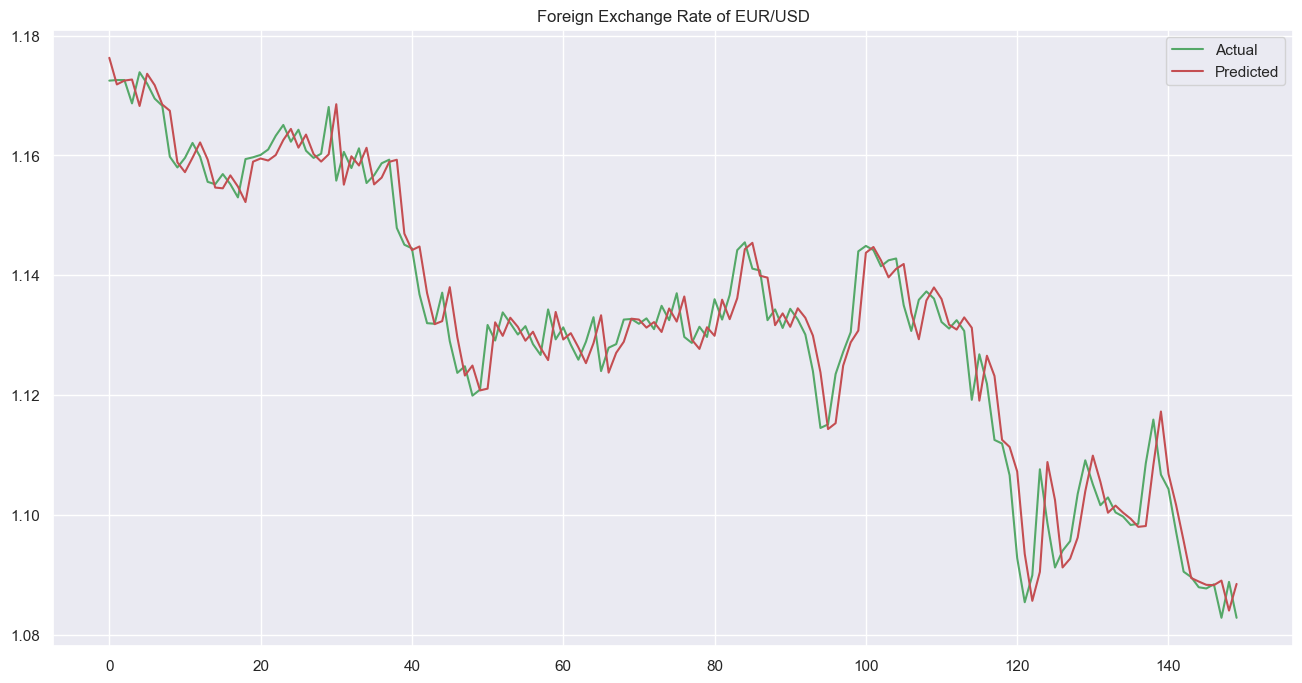

In [70]:
#Visualizing the results
plt.figure(figsize=(16,8))
plt.title('Foreign Exchange Rate of EUR/USD')
plt.plot(y_test , label = 'Actual', color = 'g')
plt.plot(y_pred , label = 'Predicted', color = 'r')
plt.legend()

In [71]:
mean_squared_error(y_test, y_pred)

2.6570118732604093e-05

In [72]:
mean_absolute_error(y_test,y_pred)

0.003898439361572265

In [73]:
last_sequence = test[-look_back:]
last_sequence = last_sequence.reshape((1, look_back, 1))
prediction_1 = model.predict(last_sequence)
prediction_1 = scaler.inverse_transform(prediction_1)

1/1 [==============================] - 0s 18ms/step


In [74]:
prediction_1

array([[1.0825292]], dtype=float32)

In [75]:
spot_prediction = pd.DataFrame(prediction_1,columns = ['RNN-LSTM'])
spot_prediction

RNN-LSTM
0  1.082529

In [76]:
predictions_df = spot_prediction.join(predictions_vol)
predictions_df

RNN-LSTM   Garch-N   Garch T  E-Garch N  E-Garch T
0  1.082529  0.070223  0.072302   0.067745   0.068877

## Interest Rate Forecasting-Using Time-Series Models##

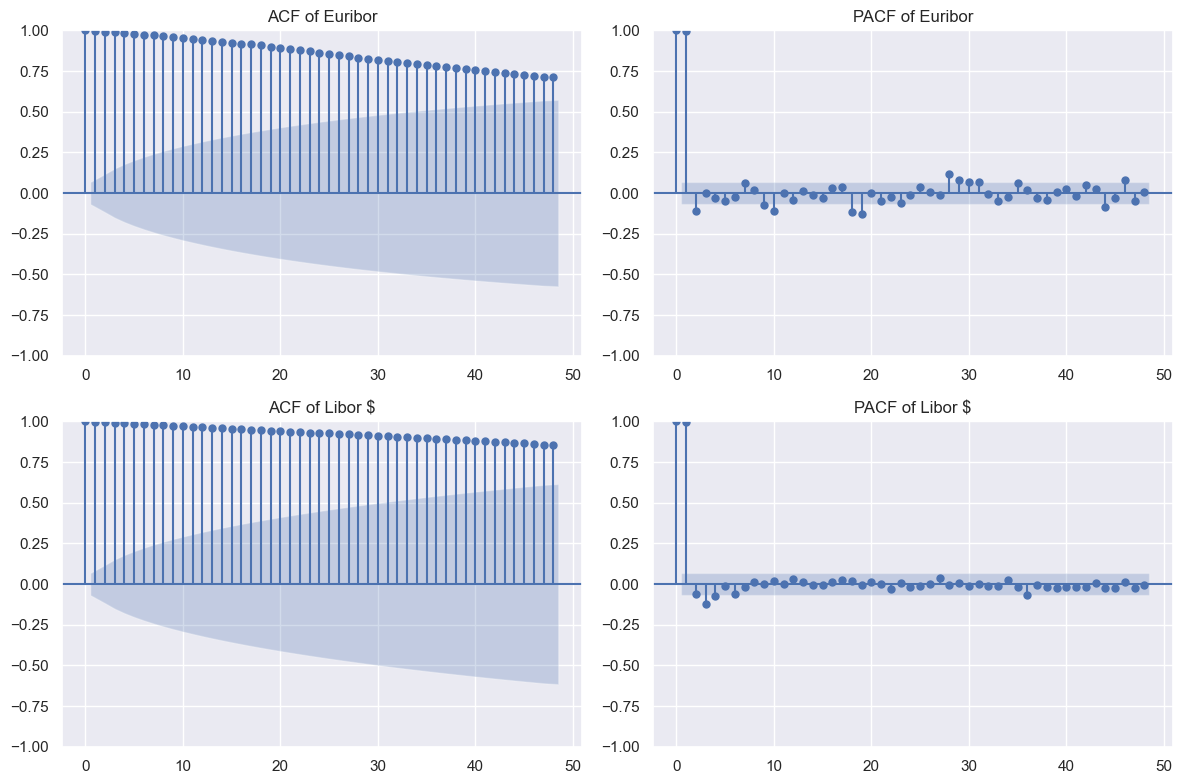

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1 - ACF of 'Euribor'
plot_acf(fwd_rates['Euribor'], lags=48, ax=axs[0, 0])
axs[0, 0].set_title('ACF of Euribor')

# Plot 2 - PACF of 'Euribor'
plot_pacf(fwd_rates['Euribor'], lags=48, ax=axs[0, 1])
axs[0, 1].set_title('PACF of Euribor')

# Plot 3 - ACF of 'Libor $'
plot_acf(fwd_rates['Libor $'], lags=48, ax=axs[1, 0])
axs[1, 0].set_title('ACF of Libor $')

# Plot 4 - PACF of 'Libor $'
plot_pacf(fwd_rates['Libor $'], lags=48, ax=axs[1, 1])
axs[1, 1].set_title('PACF of Libor $')

plt.tight_layout()
plt.show()

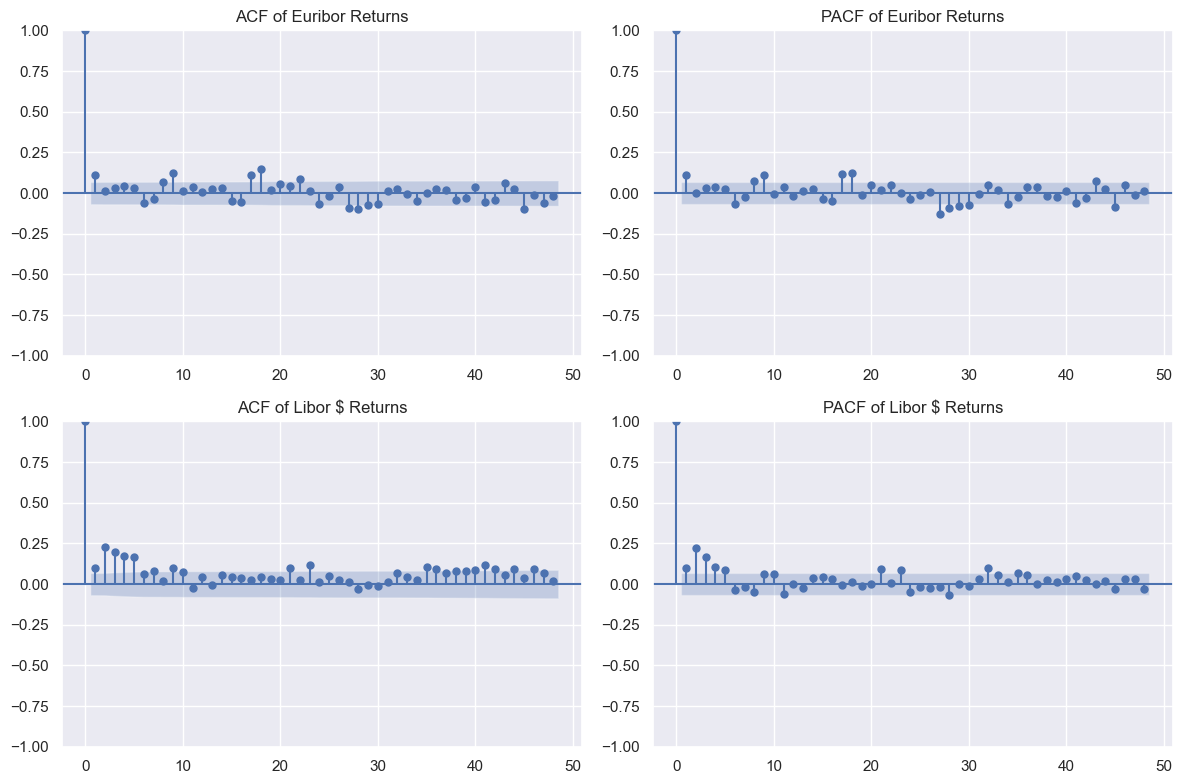

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1 - ACF of 'Euribor'
plot_acf(fwd_rates['Euribor'].diff().dropna(), lags=48, ax=axs[0, 0])
axs[0, 0].set_title('ACF of Euribor Returns')

# Plot 2 - PACF of 'Euribor'
plot_pacf(fwd_rates['Euribor'].diff().dropna(), lags=48, ax=axs[0, 1])
axs[0, 1].set_title('PACF of Euribor Returns')

# Plot 3 - ACF of 'Libor $'
plot_acf(np.log(fwd_rates['Libor $']).diff().dropna(), lags=48, ax=axs[1, 0])
axs[1, 0].set_title('ACF of Libor $ Returns')

# Plot 4 - PACF of 'Libor $'
plot_pacf(np.log(fwd_rates['Libor $']).diff().dropna(), lags=48, ax=axs[1, 1])
axs[1, 1].set_title('PACF of Libor $ Returns')

plt.tight_layout()
plt.show()

In [79]:
model = pm.auto_arima(fwd_rates['Euribor'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13614.597, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13608.603, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13616.591, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13616.568, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13609.795, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13614.594, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13602.559, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-13618.090, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-13616.093, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13616.095, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13618.062, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13603.795, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.017 seconds
                               SARIMAX Results                  

In [80]:
model_1 = pm.auto_arima(fwd_rates['Libor $'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11603.820, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11603.866, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11642.602, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11605.866, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11599.090, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11812.995, Time=0.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11865.918, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11860.963, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11804.567, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-11866.994, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-11813.368, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-11862.084, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-11808.178, Time=0.13 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 3.015 seco

In [81]:
libor_4 = ARIMA(fwd_rates['Libor $'],order = (4,1,0))
libor = libor_4.fit()
libor.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Libor $   No. Observations:                  835
Model:                 ARIMA(4, 1, 0)   Log Likelihood                5941.177
Date:                Fri, 04 Aug 2023   AIC                         -11872.354
Time:                        14:08:59   BIC                         -11848.723
Sample:                             0   HQIC                        -11863.294
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0399      0.009      4.490      0.000       0.022       0.057
ar.L2          0.4417      0.007     65.230      0.000       0.428       0.455
ar.L3          0.2562      0.004     62.894      0.000       0.248       0.264
ar.L4         -0.0939      0.002    -46.335      0.000      -0.098      -0.090
sigma2      3.788e-08   5.62e-10     67.393      0.000    3.68e-08     3.9e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30497.87
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -1.63
Prob(H) (two-sided):                  0.02   Kurtosis:                        32.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+17. Standard errors may be unstable.
"""

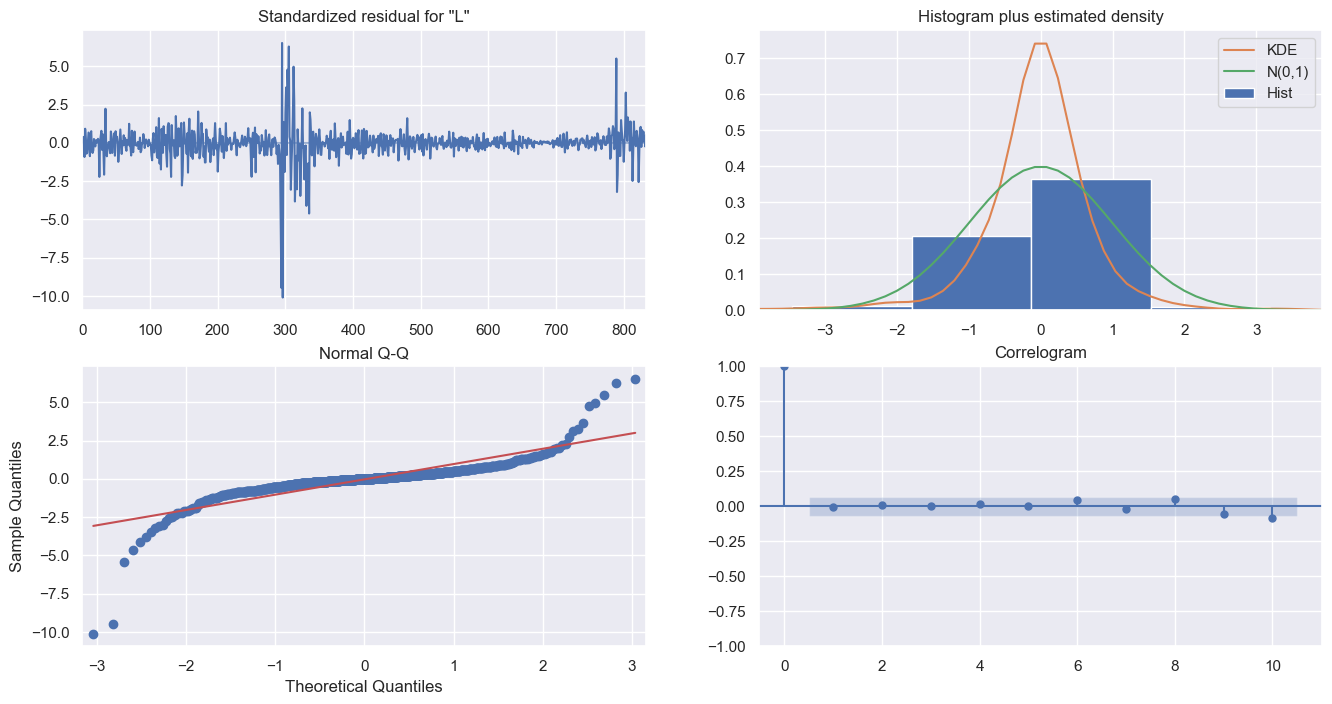

In [82]:
libor.plot_diagnostics()
plt.show()

In [83]:
libor_4_1 = ARIMA(fwd_rates['Libor $'],order = (4,1,1))
libor_1 = libor_4_1.fit()
libor_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Libor $   No. Observations:                  835
Model:                 ARIMA(4, 1, 1)   Log Likelihood                5941.189
Date:                Fri, 04 Aug 2023   AIC                         -11870.377
Time:                        14:09:00   BIC                         -11842.020
Sample:                             0   HQIC                        -11859.505
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0978      0.005     21.303      0.000       0.089       0.107
ar.L2          0.4344      0.006     72.710      0.000       0.423       0.446
ar.L3          0.2309      0.004     61.954      0.000       0.224       0.238
ar.L4         -0.0939      0.002    -45.818      0.000      -0.098      -0.090
ma.L1         -0.0580      0.005    -12.293      0.000      -0.067      -0.049
sigma2      3.763e-08   5.44e-10     69.139      0.000    3.66e-08    3.87e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30956.43
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -1.63
Prob(H) (two-sided):                  0.01   Kurtosis:                        32.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+17. Standard errors may be unstable.
"""

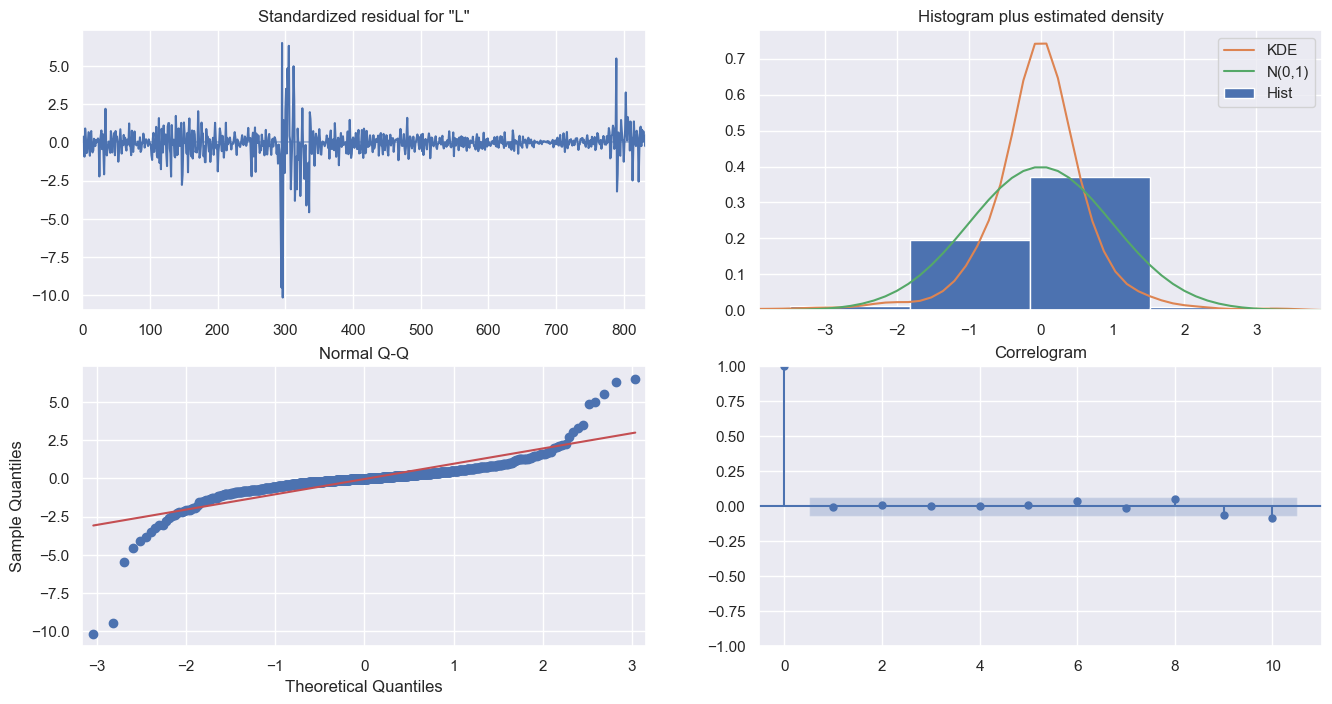

In [84]:
libor_1.plot_diagnostics()
plt.show()

In [85]:
euribor_1_0 = ARIMA(fwd_rates['Euribor'],order = (1,1,0))
euribor = euribor_1_0.fit()
euribor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Euribor   No. Observations:                  835
Model:                 ARIMA(1, 1, 0)   Log Likelihood                6811.045
Date:                Fri, 04 Aug 2023   AIC                         -13618.090
Time:                        14:09:01   BIC                         -13608.638
Sample:                             0   HQIC                        -13614.466
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1097   3.59e-20   3.06e+18      0.000       0.110       0.110
sigma2      4.555e-09   8.51e-11     53.499      0.000    4.39e-09    4.72e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7828.64
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+25. Standard errors may be unstable.
"""

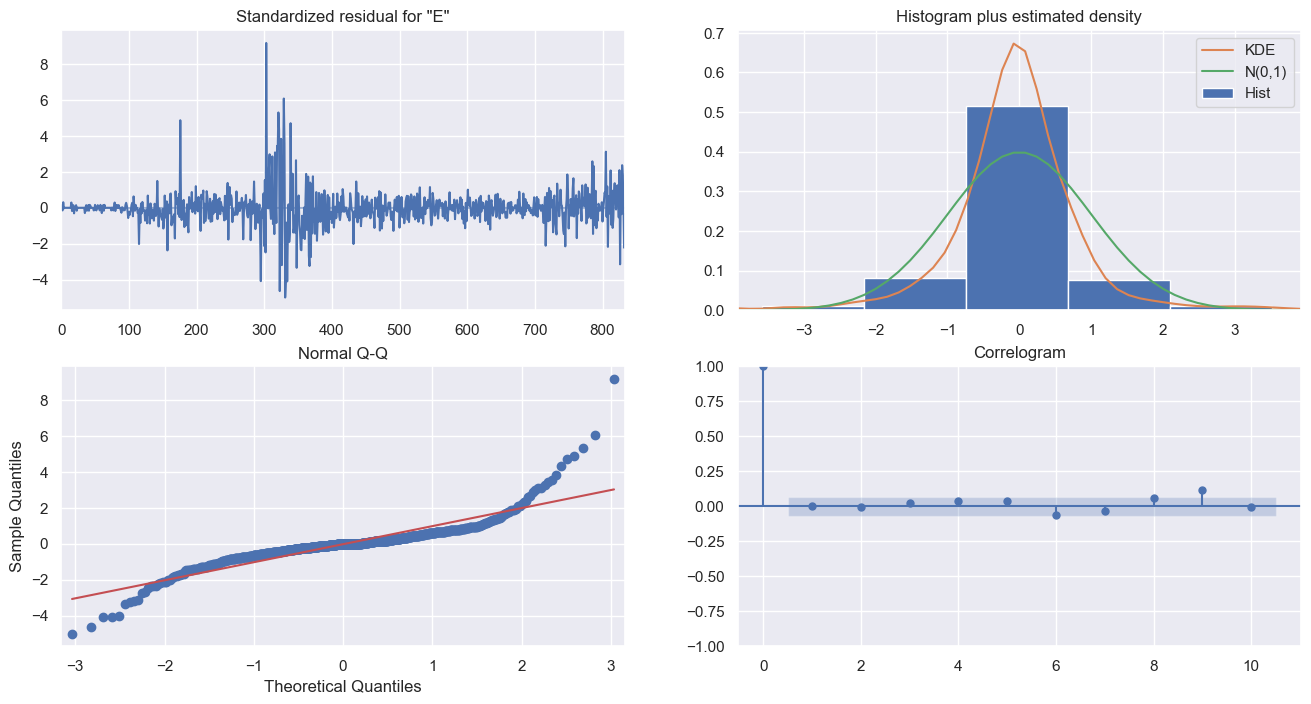

In [86]:
euribor.plot_diagnostics()
plt.show()

In [87]:
euribor_1_2 = ARIMA(fwd_rates['Euribor'],order = (1,1,2))
euribor_1 = euribor_1_2.fit()
euribor_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Euribor   No. Observations:                  835
Model:                 ARIMA(1, 1, 2)   Log Likelihood                6812.100
Date:                Fri, 04 Aug 2023   AIC                         -13616.199
Time:                        14:09:02   BIC                         -13597.294
Sample:                             0   HQIC                        -13608.951
                                - 835                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9431      0.001    704.228      0.000       0.940       0.946
ma.L1         -0.8352      0.001   -718.286      0.000      -0.838      -0.833
ma.L2         -0.0943      0.001    -88.249      0.000      -0.096      -0.092
sigma2      4.757e-09    8.5e-11     55.970      0.000    4.59e-09    4.92e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8037.92
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.13e+16. Standard errors may be unstable.
"""

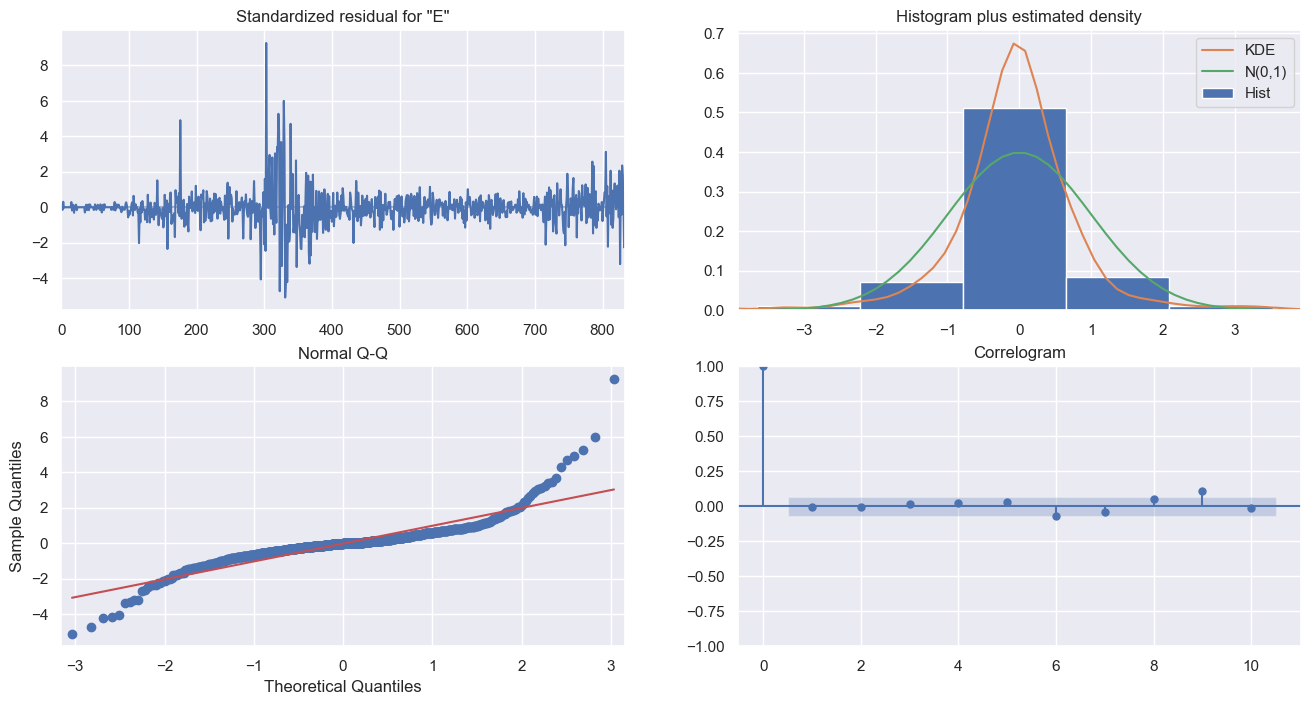

In [88]:
euribor_1.plot_diagnostics()
plt.show()

In [89]:
size = int(len(fwd_rates['Libor $']) - 0.2*len(fwd_rates['Libor $']))
train, test = fwd_rates['Libor $'][0:size], fwd_rates['Libor $'][size:len(fwd_rates['Libor $'])]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(4,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Libor Rate = %f, Expected Libor Rate = %f' % ((yhat), (observed)))

error = mean_squared_error(test, predictions)
error_1 = mean_absolute_error(test,predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.15f' % error)
print('Test MAE: %.15f' % error_1)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


Predicted Libor Rate = 0.001277, Expected Libor Rate = 0.001218
Predicted Libor Rate = 0.001212, Expected Libor Rate = 0.001237
Predicted Libor Rate = 0.001208, Expected Libor Rate = 0.001208
Predicted Libor Rate = 0.001195, Expected Libor Rate = 0.001199
Predicted Libor Rate = 0.001199, Expected Libor Rate = 0.001199
Predicted Libor Rate = 0.001185, Expected Libor Rate = 0.001196
Predicted Libor Rate = 0.001197, Expected Libor Rate = 0.001189
Predicted Libor Rate = 0.001189, Expected Libor Rate = 0.001176
Predicted Libor Rate = 0.001172, Expected Libor Rate = 0.001155
Predicted Libor Rate = 0.001147, Expected Libor Rate = 0.001146
Predicted Libor Rate = 0.001134, Expected Libor Rate = 0.001160
Predicted Libor Rate = 0.001152, Expected Libor Rate = 0.001158
Predicted Libor Rate = 0.001164, Expected Libor Rate = 0.001141
Predicted Libor Rate = 0.001144, Expected Libor Rate = 0.001158
Predicted Libor Rate = 0.001148, Expected Libor Rate = 0.0011

Predicted Libor Rate = 0.004809, Expected Libor Rate = 0.004639
Predicted Libor Rate = 0.004591, Expected Libor Rate = 0.004879
Predicted Libor Rate = 0.004818, Expected Libor Rate = 0.004976
Predicted Libor Rate = 0.005043, Expected Libor Rate = 0.005079
Predicted Libor Rate = 0.005201, Expected Libor Rate = 0.005230
Predicted Libor Rate = 0.005285, Expected Libor Rate = 0.005043
Predicted Libor Rate = 0.005121, Expected Libor Rate = 0.005109
Predicted Libor Rate = 0.005059, Expected Libor Rate = 0.005221
Predicted Libor Rate = 0.005190, Expected Libor Rate = 0.005831
Predicted Libor Rate = 0.005932, Expected Libor Rate = 0.006101
Predicted Libor Rate = 0.006402, Expected Libor Rate = 0.006429
Predicted Libor Rate = 0.006706, Expected Libor Rate = 0.007030
Predicted Libor Rate = 0.007211, Expected Libor Rate = 0.007450
Predicted Libor Rate = 0.007790, Expected Libor Rate = 0.008029
Predicted Libor Rate = 0.008366, Expected Libor Rate = 0.008260
Predicted Libor Rate = 0.008581, Expecte

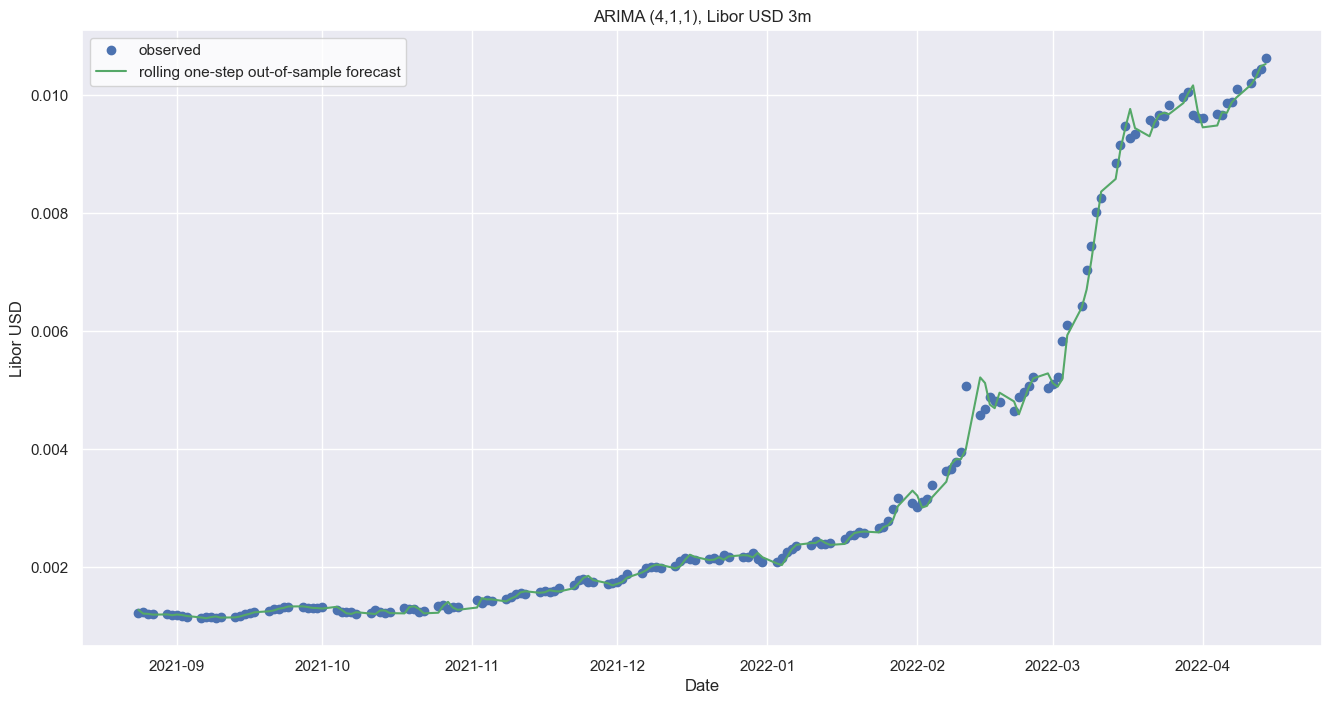

In [90]:
fig, ax = plt.subplots()
ax.set(title='ARIMA (4,1,1), Libor USD 3m', xlabel='Date', ylabel='Libor USD')
ax.plot(fwd_rates['Libor $'][-167:], 'o', label='observed')
ax.plot((predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [91]:
size = int(len(fwd_rates['Libor $']) - 0.2*len(fwd_rates['Libor $']))
train, test = fwd_rates['Libor $'][0:size], fwd_rates['Libor $'][size:len(fwd_rates['Libor $'])]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Libor Rate = %f, Expected Libor Rate = %f' % ((yhat), (observed)))

error = mean_squared_error(test, predictions)
error_1 = mean_absolute_error(test,predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.15f' % error)
print('Test MAE: %.15f' % error_1)

predictions_series_1 = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


Predicted Libor Rate = 0.001276, Expected Libor Rate = 0.001218
Predicted Libor Rate = 0.001213, Expected Libor Rate = 0.001237
Predicted Libor Rate = 0.001208, Expected Libor Rate = 0.001208
Predicted Libor Rate = 0.001195, Expected Libor Rate = 0.001199
Predicted Libor Rate = 0.001200, Expected Libor Rate = 0.001199
Predicted Libor Rate = 0.001184, Expected Libor Rate = 0.001196
Predicted Libor Rate = 0.001198, Expected Libor Rate = 0.001189
Predicted Libor Rate = 0.001189, Expected Libor Rate = 0.001176
Predicted Libor Rate = 0.001172, Expected Libor Rate = 0.001155
Predicted Libor Rate = 0.001147, Expected Libor Rate = 0.001146
Predicted Libor Rate = 0.001134, Expected Libor Rate = 0.001160
Predicted Libor Rate = 0.001152, Expected Libor Rate = 0.001158
Predicted Libor Rate = 0.001164, Expected Libor Rate = 0.001141
Predicted Libor Rate = 0.001144, Expected Libor Rate = 0.001158
Predicted Libor Rate = 0.001148, Expected Libor Rate = 0.0011

Predicted Libor Rate = 0.004805, Expected Libor Rate = 0.004639
Predicted Libor Rate = 0.004588, Expected Libor Rate = 0.004879
Predicted Libor Rate = 0.004819, Expected Libor Rate = 0.004976
Predicted Libor Rate = 0.005045, Expected Libor Rate = 0.005079
Predicted Libor Rate = 0.005204, Expected Libor Rate = 0.005230
Predicted Libor Rate = 0.005281, Expected Libor Rate = 0.005043
Predicted Libor Rate = 0.005122, Expected Libor Rate = 0.005109
Predicted Libor Rate = 0.005057, Expected Libor Rate = 0.005221
Predicted Libor Rate = 0.005188, Expected Libor Rate = 0.005831
Predicted Libor Rate = 0.005936, Expected Libor Rate = 0.006101
Predicted Libor Rate = 0.006403, Expected Libor Rate = 0.006429
Predicted Libor Rate = 0.006706, Expected Libor Rate = 0.007030
Predicted Libor Rate = 0.007203, Expected Libor Rate = 0.007450
Predicted Libor Rate = 0.007792, Expected Libor Rate = 0.008029
Predicted Libor Rate = 0.008364, Expected Libor Rate = 0.008260
Predicted Libor Rate = 0.008576, Expecte

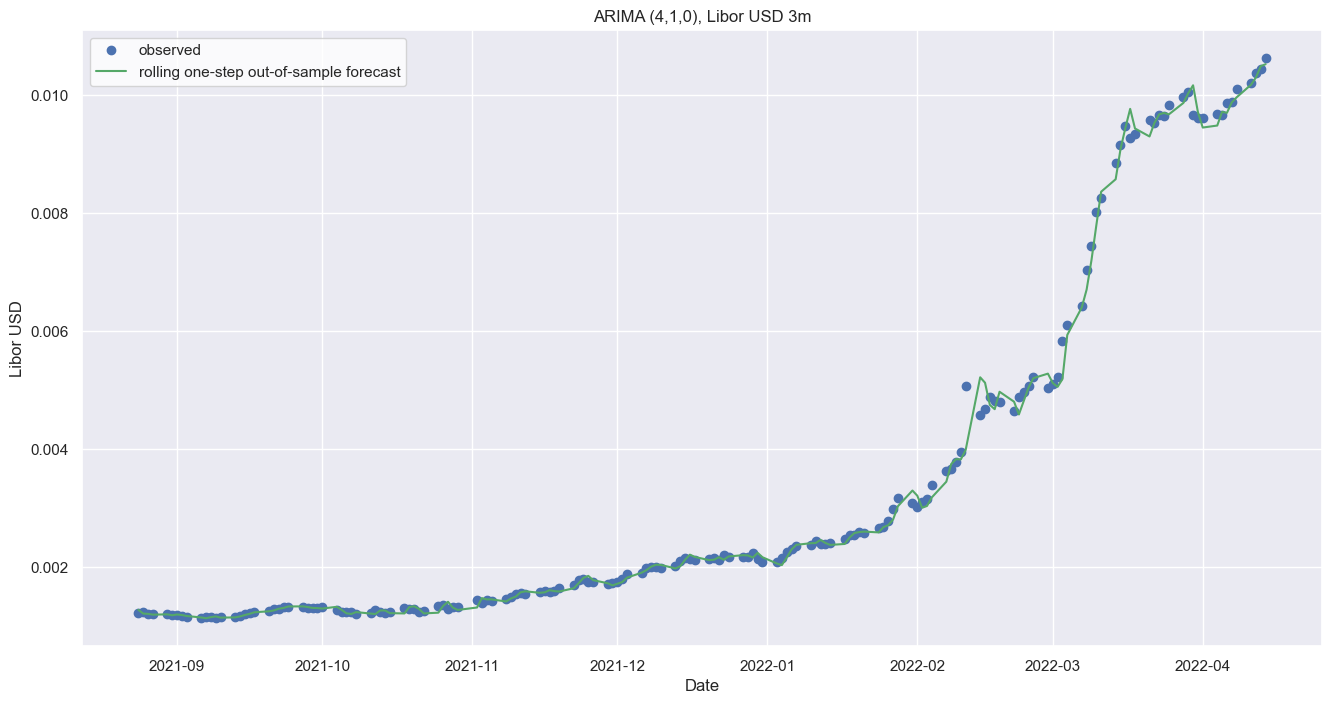

In [92]:
fig, ax = plt.subplots()
ax.set(title='ARIMA (4,1,0), Libor USD 3m', xlabel='Date', ylabel='Libor USD')
ax.plot(fwd_rates['Libor $'][-167:], 'o', label='observed')
ax.plot((predictions_series_1), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

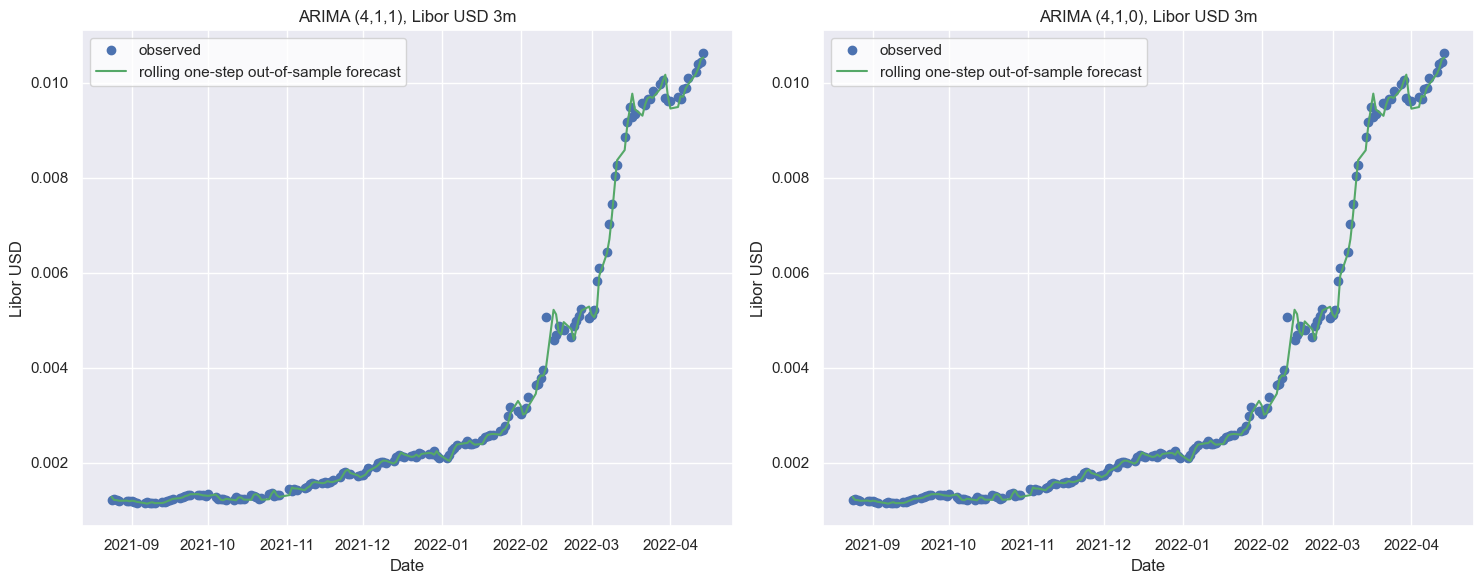

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - ARIMA (4,1,1), Libor USD 3m
axs[0].set(title='ARIMA (4,1,1), Libor USD 3m', xlabel='Date', ylabel='Libor USD')
axs[0].plot(fwd_rates['Libor $'][-167:], 'o', label='observed')
axs[0].plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend0 = axs[0].legend(loc='upper left')
legend0.get_frame().set_facecolor('w')

# Second subplot - ARIMA (4,1,0), Libor USD 3m
axs[1].set(title='ARIMA (4,1,0), Libor USD 3m', xlabel='Date', ylabel='Libor USD')
axs[1].plot(fwd_rates['Libor $'][-167:], 'o', label='observed')
axs[1].plot(predictions_series_1, 'g', label='rolling one-step out-of-sample forecast')
legend1 = axs[1].legend(loc='upper left')
legend1.get_frame().set_facecolor('w')

plt.tight_layout()
plt.show()

In [94]:
size = int(len(fwd_rates['Euribor']) - 0.2*len(fwd_rates['Euribor']))
train, test = fwd_rates['Euribor'][0:size], fwd_rates['Euribor'][size:len(fwd_rates['Euribor'])]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Euribor Rate = %f, Expected Euribor Rate = %f' % ((yhat), (observed)))

error = mean_squared_error(test, predictions)
error_1 = mean_absolute_error(test,predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.15f' % error)
print('Test MAE: %.15f' % error_1)

predictions_series_2 = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


Predicted Euribor Rate = -0.005491, Expected Euribor Rate = -0.005490
Predicted Euribor Rate = -0.005490, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005501, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005500, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005500, Expected Euribor Rate = -0.005490
Predicted Euribor Rate = -0.005489, Expected Euribor Rate = -0.005480
Predicted Euribor Rate = -0.005479, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005503, Expected Euribor Rate = -0.005510
Predicted Euribor Rate = -0.005511, Expected Euribor Rate = -0.005480
Predicted Euribor Rate = -0.005476, Expected Euribor Rate = -0.005490
Predicted Euribor Rate = -0.005491, Expected Euribor Rate = -0.005430
Predicted Euribor Rate = -0.005421, Expected Euribor Rate = -0.005410
Predicted Euribor Rate = -0.005407, Expected Euribor Rate = -0.005430
Predicted Euribor Rate = -0.005433, Expected Eu

Predicted Euribor Rate = -0.005515, Expected Euribor Rate = -0.005480
Predicted Euribor Rate = -0.005476, Expected Euribor Rate = -0.005300
Predicted Euribor Rate = -0.005276, Expected Euribor Rate = -0.005380
Predicted Euribor Rate = -0.005390, Expected Euribor Rate = -0.005230
Predicted Euribor Rate = -0.005211, Expected Euribor Rate = -0.005280
Predicted Euribor Rate = -0.005286, Expected Euribor Rate = -0.005230
Predicted Euribor Rate = -0.005224, Expected Euribor Rate = -0.005160
Predicted Euribor Rate = -0.005151, Expected Euribor Rate = -0.005230
Predicted Euribor Rate = -0.005239, Expected Euribor Rate = -0.005240
Predicted Euribor Rate = -0.005241, Expected Euribor Rate = -0.005290
Predicted Euribor Rate = -0.005296, Expected Euribor Rate = -0.005280
Predicted Euribor Rate = -0.005279, Expected Euribor Rate = -0.005270
Predicted Euribor Rate = -0.005269, Expected Euribor Rate = -0.005280
Predicted Euribor Rate = -0.005281, Expected Euribor Rate = -0.005290
Predicted Euribor Ra

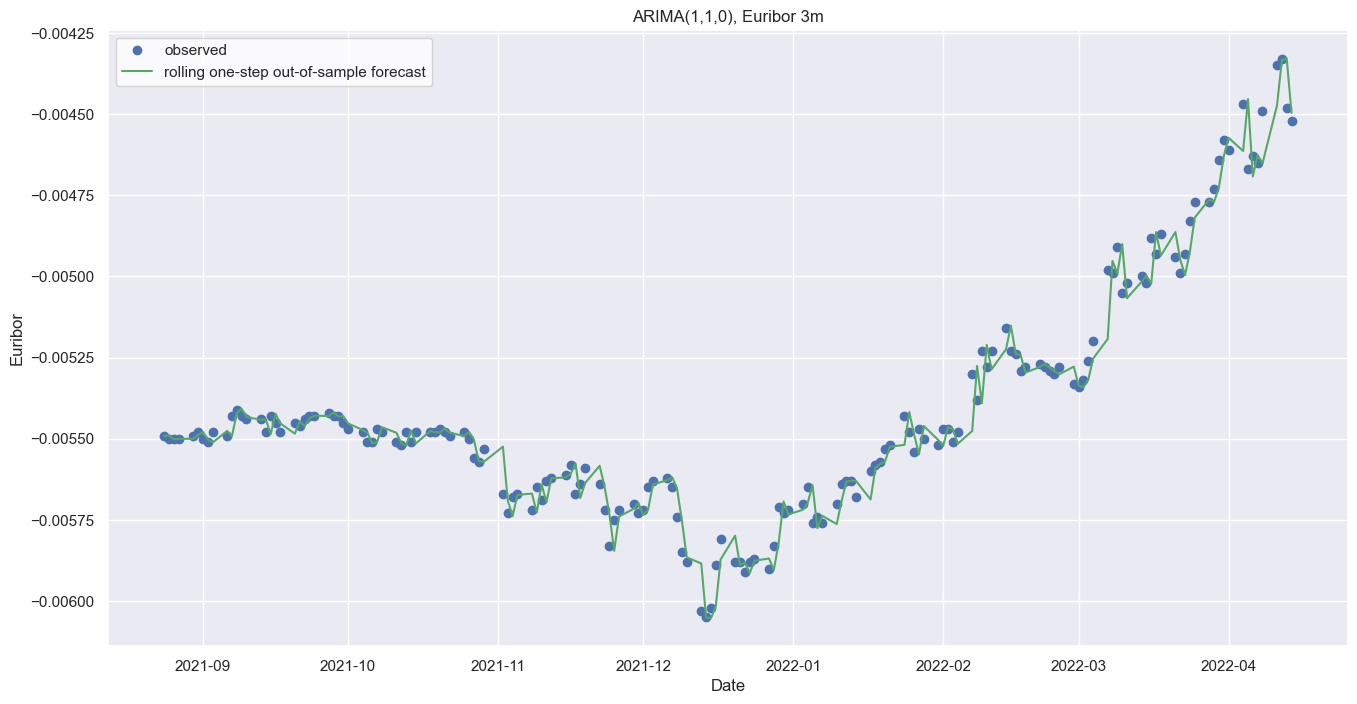

In [95]:
fig, ax = plt.subplots()
ax.set(title='ARIMA(1,1,0), Euribor 3m', xlabel='Date', ylabel='Euribor')
ax.plot(fwd_rates['Euribor'][-167:], 'o', label='observed')
ax.plot((predictions_series_2), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [96]:
size = int(len(fwd_rates['Euribor']) - 0.2*len(fwd_rates['Euribor']))
train, test = fwd_rates['Euribor'][0:size], fwd_rates['Euribor'][size:len(fwd_rates['Euribor'])]
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(historical, order=(1,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Euribor Rate = %f, Expected Euribor Rate = %f' % ((yhat), (observed)))

error = mean_squared_error(test, predictions)
error_1 = mean_absolute_error(test,predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.15f' % error)
print('Test MAE: %.15f' % error_1)

predictions_series_3 = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


Predicted Euribor Rate = -0.005492, Expected Euribor Rate = -0.005490
Predicted Euribor Rate = -0.005490, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005501, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005500, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005500, Expected Euribor Rate = -0.005490
Predicted Euribor Rate = -0.005489, Expected Euribor Rate = -0.005480
Predicted Euribor Rate = -0.005479, Expected Euribor Rate = -0.005500
Predicted Euribor Rate = -0.005503, Expected Euribor Rate = -0.005510
Predicted Euribor Rate = -0.005511, Expected Euribor Rate = -0.005480
Predicted Euribor Rate = -0.005476, Expected Euribor Rate = -0.005490
Predicted Euribor Rate = -0.005492, Expected Euribor Rate = -0.005430
Predicted Euribor Rate = -0.005421, Expected Euribor Rate = -0.005410
Predicted Euribor Rate = -0.005409, Expected Euribor Rate = -0.005430
Predicted Euribor Rate = -0.005433, Expected Eu

Predicted Euribor Rate = -0.005515, Expected Euribor Rate = -0.005480
Predicted Euribor Rate = -0.005475, Expected Euribor Rate = -0.005300
Predicted Euribor Rate = -0.005277, Expected Euribor Rate = -0.005380
Predicted Euribor Rate = -0.005396, Expected Euribor Rate = -0.005230
Predicted Euribor Rate = -0.005209, Expected Euribor Rate = -0.005280
Predicted Euribor Rate = -0.005290, Expected Euribor Rate = -0.005230
Predicted Euribor Rate = -0.005223, Expected Euribor Rate = -0.005160
Predicted Euribor Rate = -0.005153, Expected Euribor Rate = -0.005230
Predicted Euribor Rate = -0.005240, Expected Euribor Rate = -0.005240
Predicted Euribor Rate = -0.005240, Expected Euribor Rate = -0.005290
Predicted Euribor Rate = -0.005296, Expected Euribor Rate = -0.005280
Predicted Euribor Rate = -0.005278, Expected Euribor Rate = -0.005270
Predicted Euribor Rate = -0.005269, Expected Euribor Rate = -0.005280
Predicted Euribor Rate = -0.005281, Expected Euribor Rate = -0.005290
Predicted Euribor Ra

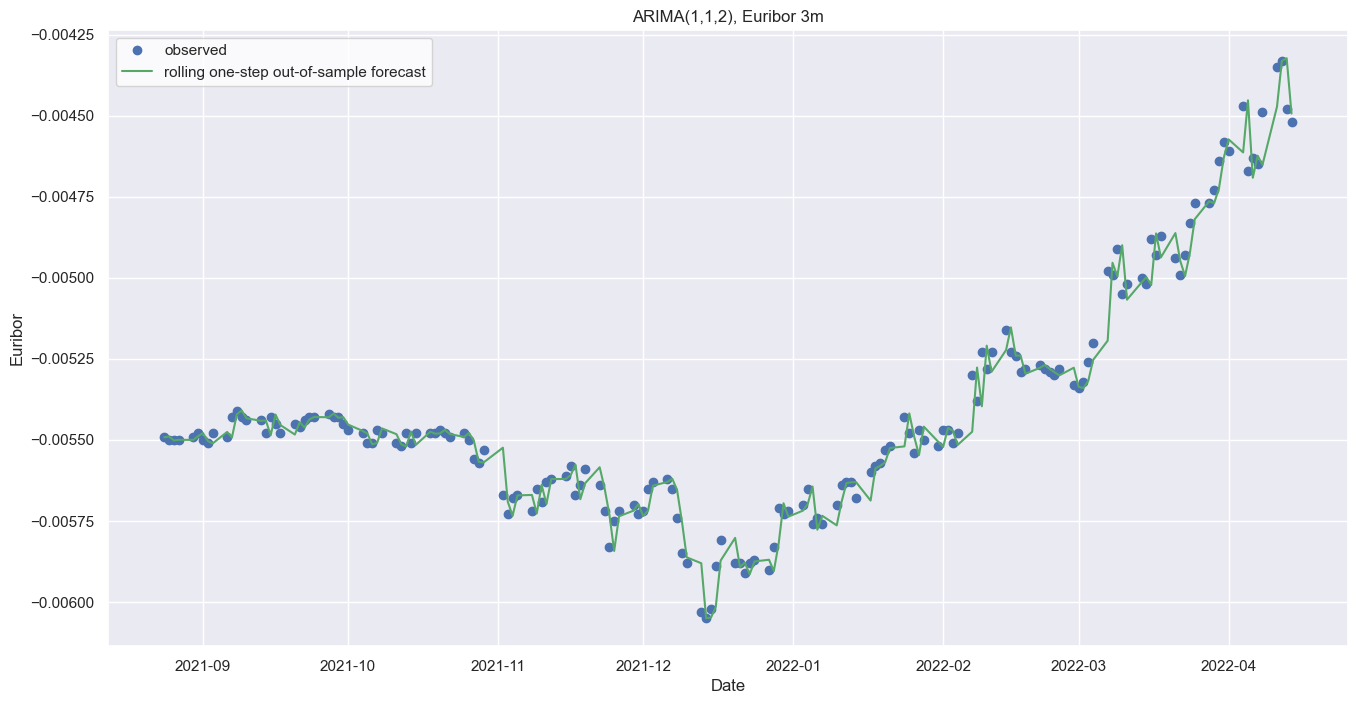

In [97]:
fig, ax = plt.subplots()
ax.set(title='ARIMA(1,1,2), Euribor 3m', xlabel='Date', ylabel='Euribor')
ax.plot(fwd_rates['Euribor'][-167:], 'o', label='observed')
ax.plot((predictions_series_3), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

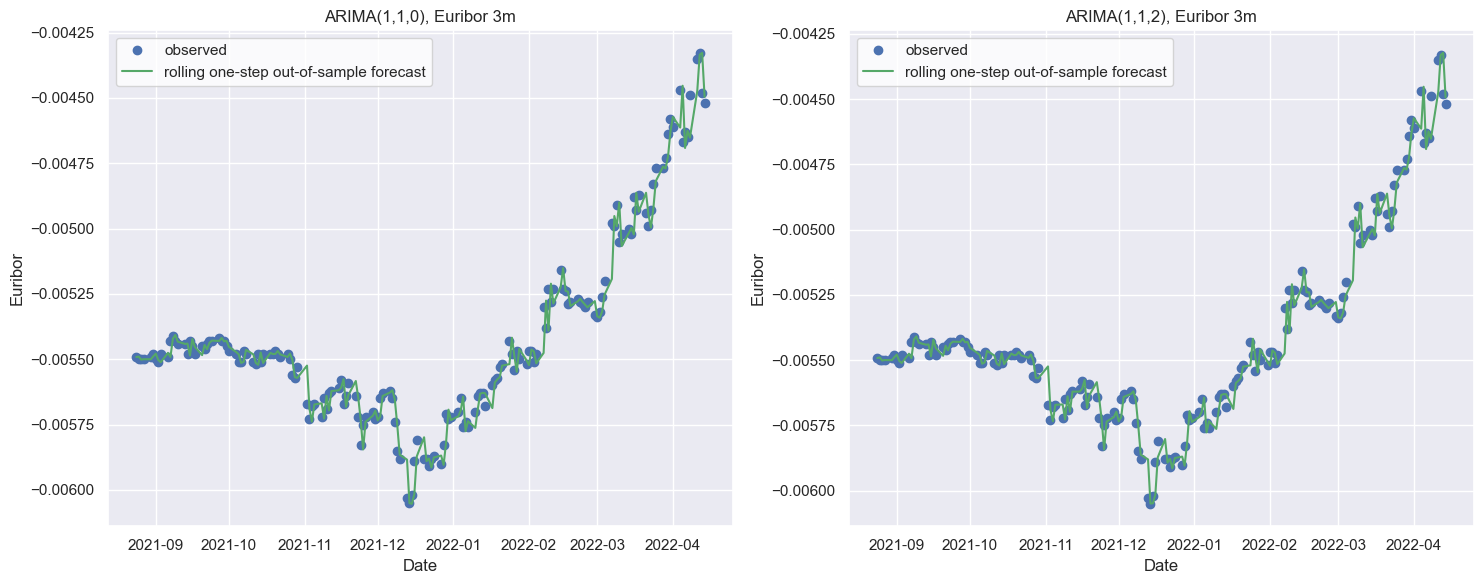

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - ARIMA (1,1,0), Euribor 3m
axs[0].set(title='ARIMA(1,1,0), Euribor 3m', xlabel='Date', ylabel='Euribor')
axs[0].plot(fwd_rates['Euribor'][-167:], 'o', label='observed')
axs[0].plot(predictions_series_2, 'g', label='rolling one-step out-of-sample forecast')
legend0 = axs[0].legend(loc='upper left')
legend0.get_frame().set_facecolor('w')

# Second subplot - ARIMA (1,1,2), Euribor 3m
axs[1].set(title='ARIMA(1,1,2), Euribor 3m', xlabel='Date', ylabel='Euribor')
axs[1].plot(fwd_rates['Euribor'][-167:], 'o', label='observed')
axs[1].plot(predictions_series_3, 'g', label='rolling one-step out-of-sample forecast')
legend1 = axs[1].legend(loc='upper left')
legend1.get_frame().set_facecolor('w')

plt.tight_layout()
plt.show()


In [99]:
# Forecast
libor_forecast_1 = libor.get_forecast()
libor_forecast_2 = libor_1.get_forecast()
libor_forecast_1.summary_frame()

Libor $      mean   mean_se  mean_ci_lower  mean_ci_upper
835      0.010694  0.000195       0.010312       0.011075

In [100]:
libor_forecast_2.summary_frame()

Libor $      mean   mean_se  mean_ci_lower  mean_ci_upper
835      0.010694  0.000195       0.010313       0.011076

In [101]:
# Forecast
libor_forecast_1 = libor.forecast(1)
libor_forecast_2 = libor_1.forecast(1)

In [102]:
euribor_forecast_1= euribor.get_forecast()
euribor_forecast_2= euribor_1.get_forecast()

In [103]:
euribor_forecast_1.summary_frame()

Euribor      mean   mean_se  mean_ci_lower  mean_ci_upper
835     -0.004524  0.000068      -0.004658      -0.004391

In [104]:
euribor_forecast_2.summary_frame()

Euribor      mean   mean_se  mean_ci_lower  mean_ci_upper
835     -0.004521  0.000068      -0.004654      -0.004387

In [105]:
# Forecast
euribor_forecast_1= euribor.forecast(1)
euribor_forecast_2= euribor_1.forecast(1)

In [106]:
rates_predictions = pd.DataFrame()
rates_predictions['Euribor 1'] = euribor_forecast_1.values
rates_predictions['Euribor 2'] = euribor_forecast_2.values
rates_predictions['Libor 1'] = libor_forecast_1.values
rates_predictions['Libor 2'] = libor_forecast_2.values
rates_predictions

Euribor 1  Euribor 2   Libor 1   Libor 2
0  -0.004524  -0.004521  0.010694  0.010694

In [107]:
predictions_full = predictions_df.join(rates_predictions)
predictions_full

RNN-LSTM   Garch-N   Garch T  E-Garch N  E-Garch T  Euribor 1  Euribor 2  \
0  1.082529  0.070223  0.072302   0.067745   0.068877  -0.004524  -0.004521   

    Libor 1   Libor 2  
0  0.010694  0.010694

In [108]:
forecast_call_1 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 1'],predictions_full['Libor 1'],predictions_full['Garch-N'],0.25,'call')
forecast_call_2 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 1'],predictions_full['Libor 1'],predictions_full['Garch T'],0.25,'call')


forecast_put_1 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 1'],predictions_full['Libor 1'],predictions_full['Garch-N'],0.25,'put')
forecast_put_2 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 1'],predictions_full['Libor 1'],predictions_full['Garch T'],0.25,'put')


In [109]:
option_predictions = pd.DataFrame()
option_predictions['call_1'] = forecast_call_1.values
option_predictions['call_2'] = forecast_call_2.values

option_predictions['put_1'] = forecast_put_1.values
option_predictions['put_2'] = forecast_put_2.values
option_predictions


call_1    call_2     put_1     put_2
0  0.01654  0.017006  0.012425  0.012891

In [110]:
forecast_call_1_1 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 2'],predictions_full['Libor 2'],predictions_full['Garch-N'],0.25,'call')
forecast_call_2_1 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 2'],predictions_full['Libor 2'],predictions_full['Garch T'],0.25,'call')


forecast_put_1_1 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 2'],predictions_full['Libor 2'],predictions_full['Garch-N'],0.25,'put')
forecast_put_2_1 = BS_Pricer(predictions_full['RNN-LSTM'],predictions_full['RNN-LSTM'],predictions_full['Euribor 2'],predictions_full['Libor 2'],predictions_full['Garch T'],0.25,'put')


In [111]:
option_predictions_1 = pd.DataFrame()
option_predictions_1['call_1'] = forecast_call_1_1.values
option_predictions_1['call_2'] = forecast_call_2_1.values

option_predictions_1['put_1'] = forecast_put_1_1.values
option_predictions_1['put_2'] = forecast_put_2_1.values
option_predictions_1


call_1    call_2     put_1     put_2
0  0.01654  0.017006  0.012426  0.012891